# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

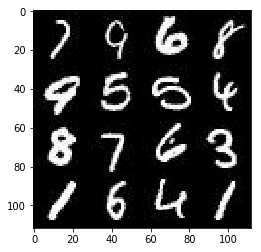

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

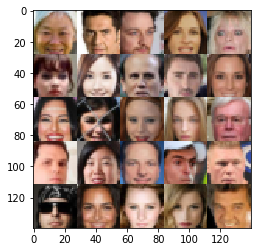

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_placeholder = tf.placeholder(tf.float32, shape=(None,image_width,image_height,image_channels))
    z_placeholder = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_placeholder = tf.placeholder(tf.float32,shape=())

    return real_placeholder, z_placeholder, learning_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        # First layer. (None, 28, 28, 3)
        x1 = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, 
                              padding="same", strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x=x1, keep_prob=0.8)
        
        # Second layer. (None, 14,14,32)
        x2 = tf.layers.conv2d(inputs=x1, filters=64, kernel_size=5, 
                              padding="same", strides=2,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x=x2, keep_prob=0.8)
        
        # Third layer. (None,7,7,64)
        x3 = tf.layers.conv2d(inputs=x2, filters=128, kernel_size=5, padding="same", 
                              strides=2,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x=x3, keep_prob=0.8)
        
        # Output layer. ()
        flat = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(flat,units=1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=(not is_train)):
        
        # First Layer 
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x=x1, keep_prob=0.8)
        
        # Second Layer (7,7,512)
        x2 = tf.layers.conv2d_transpose(x1,filters=256,kernel_size=5, strides=2,
                                        padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x=x2, keep_prob=0.8)
        
        # Third layer (14,14,256)
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, 
                                        padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x=x3, keep_prob=0.8)
        
        # Output (28,28,128)
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=1, 
                                        padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        logits = tf.layers.conv2d_transpose(x4, filters=out_channel_dim, kernel_size=5, strides=1, 
                                            padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real))
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if "discriminator" in var.name]
    g_vars = [var for var in t_vars if "generator" in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, losses = [], []
    steps = 0
    if data_image_mode=="RGB":
        num_channel=3
    elif data_image_mode=="L":
        num_channel=1
    
    input_real, input_z, learning_p = model_inputs(image_channels=num_channel,image_width=28,
                                                      image_height=28,z_dim=z_dim)
    
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z,out_channel_dim=num_channel)
    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, beta1=beta1,learning_rate=learning_rate)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random Noise for generator
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, learning_p:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count), 
                         "Discriminator loss: {:.4f}...".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g)
                         )
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    s = show_generator_output(sess=sess,n_images=16,input_z=input_z, 
                                          image_mode=data_image_mode,out_channel_dim=num_channel)
                    samples.append(s)
                    
        saver.save(sess, "./checkpoint/generator.ckpt")
        
    return losses
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator loss: 1.6181... Generator loss: 1.3684
Epoch 0/2... Discriminator loss: 1.5833... Generator loss: 5.3351
Epoch 0/2... Discriminator loss: 4.2532... Generator loss: 0.0597
Epoch 0/2... Discriminator loss: 0.8989... Generator loss: 1.4769
Epoch 0/2... Discriminator loss: 0.4353... Generator loss: 3.7211
Epoch 0/2... Discriminator loss: 0.3801... Generator loss: 4.4710
Epoch 0/2... Discriminator loss: 0.3804... Generator loss: 5.6619
Epoch 0/2... Discriminator loss: 0.3670... Generator loss: 4.4942
Epoch 0/2... Discriminator loss: 0.3692... Generator loss: 5.5353
Epoch 0/2... Discriminator loss: 0.3623... Generator loss: 5.1724


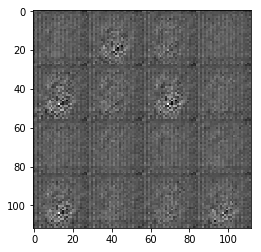

Epoch 0/2... Discriminator loss: 0.3578... Generator loss: 5.7067
Epoch 0/2... Discriminator loss: 0.3647... Generator loss: 5.2237
Epoch 0/2... Discriminator loss: 0.3492... Generator loss: 5.4822
Epoch 0/2... Discriminator loss: 0.3624... Generator loss: 5.2170
Epoch 0/2... Discriminator loss: 0.3564... Generator loss: 4.6783
Epoch 0/2... Discriminator loss: 0.3572... Generator loss: 8.6983
Epoch 0/2... Discriminator loss: 0.3509... Generator loss: 6.0323
Epoch 0/2... Discriminator loss: 0.3430... Generator loss: 5.5427
Epoch 0/2... Discriminator loss: 0.3425... Generator loss: 6.0952
Epoch 0/2... Discriminator loss: 0.3464... Generator loss: 5.5294


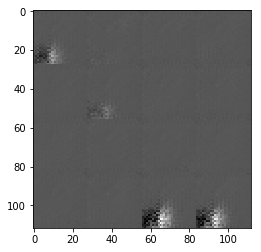

Epoch 0/2... Discriminator loss: 0.3389... Generator loss: 6.3296
Epoch 0/2... Discriminator loss: 0.3372... Generator loss: 7.6225
Epoch 0/2... Discriminator loss: 0.4006... Generator loss: 3.2428
Epoch 0/2... Discriminator loss: 0.3388... Generator loss: 6.4247
Epoch 0/2... Discriminator loss: 0.5313... Generator loss: 5.6284
Epoch 0/2... Discriminator loss: 0.3567... Generator loss: 5.6838
Epoch 0/2... Discriminator loss: 0.3405... Generator loss: 9.7800
Epoch 0/2... Discriminator loss: 0.3399... Generator loss: 6.0986
Epoch 0/2... Discriminator loss: 0.3402... Generator loss: 7.5663
Epoch 0/2... Discriminator loss: 0.3403... Generator loss: 7.3918


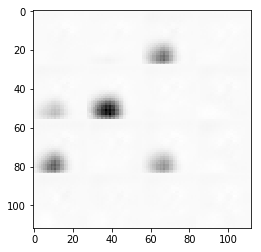

Epoch 0/2... Discriminator loss: 0.3355... Generator loss: 8.1965
Epoch 0/2... Discriminator loss: 0.3409... Generator loss: 7.6917
Epoch 0/2... Discriminator loss: 0.3463... Generator loss: 6.0254
Epoch 0/2... Discriminator loss: 0.3377... Generator loss: 8.2580
Epoch 0/2... Discriminator loss: 0.3362... Generator loss: 7.1884
Epoch 0/2... Discriminator loss: 0.3390... Generator loss: 8.6406
Epoch 0/2... Discriminator loss: 0.3388... Generator loss: 6.1577
Epoch 0/2... Discriminator loss: 0.3410... Generator loss: 9.4945
Epoch 0/2... Discriminator loss: 0.3384... Generator loss: 6.5199
Epoch 0/2... Discriminator loss: 0.3345... Generator loss: 9.5267


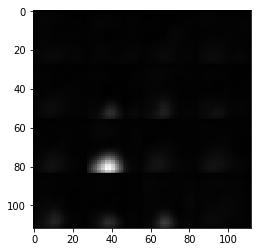

Epoch 0/2... Discriminator loss: 0.3332... Generator loss: 9.5061
Epoch 0/2... Discriminator loss: 0.3337... Generator loss: 9.6654
Epoch 0/2... Discriminator loss: 0.3401... Generator loss: 5.6812
Epoch 0/2... Discriminator loss: 0.3412... Generator loss: 6.6988
Epoch 0/2... Discriminator loss: 0.3347... Generator loss: 10.8541
Epoch 0/2... Discriminator loss: 0.3402... Generator loss: 6.5315
Epoch 0/2... Discriminator loss: 0.5339... Generator loss: 4.2903
Epoch 0/2... Discriminator loss: 0.4932... Generator loss: 3.2578
Epoch 0/2... Discriminator loss: 0.9532... Generator loss: 1.4112
Epoch 0/2... Discriminator loss: 0.4015... Generator loss: 3.4296


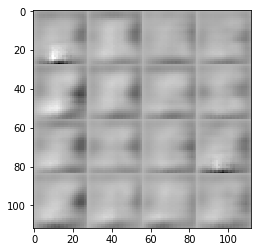

Epoch 0/2... Discriminator loss: 0.3976... Generator loss: 3.6316
Epoch 0/2... Discriminator loss: 0.4775... Generator loss: 2.3655
Epoch 0/2... Discriminator loss: 0.3571... Generator loss: 5.8581
Epoch 0/2... Discriminator loss: 0.3524... Generator loss: 5.1741
Epoch 0/2... Discriminator loss: 0.4239... Generator loss: 2.8965
Epoch 0/2... Discriminator loss: 0.5141... Generator loss: 7.1458
Epoch 0/2... Discriminator loss: 0.4540... Generator loss: 3.5976
Epoch 0/2... Discriminator loss: 1.7637... Generator loss: 0.4315
Epoch 0/2... Discriminator loss: 0.3769... Generator loss: 5.4693
Epoch 0/2... Discriminator loss: 0.3752... Generator loss: 7.1962


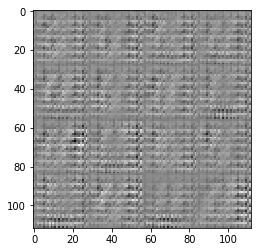

Epoch 0/2... Discriminator loss: 0.3691... Generator loss: 4.2302
Epoch 0/2... Discriminator loss: 0.4278... Generator loss: 7.9451
Epoch 0/2... Discriminator loss: 0.3553... Generator loss: 5.5068
Epoch 0/2... Discriminator loss: 0.3857... Generator loss: 3.1960
Epoch 0/2... Discriminator loss: 1.1444... Generator loss: 0.8009
Epoch 0/2... Discriminator loss: 1.3469... Generator loss: 2.6057
Epoch 0/2... Discriminator loss: 0.8557... Generator loss: 1.1162
Epoch 0/2... Discriminator loss: 0.6908... Generator loss: 2.0253
Epoch 0/2... Discriminator loss: 0.4897... Generator loss: 2.3059
Epoch 0/2... Discriminator loss: 0.7753... Generator loss: 1.9425


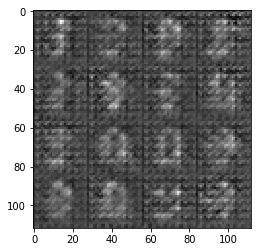

Epoch 0/2... Discriminator loss: 0.5736... Generator loss: 2.7490
Epoch 0/2... Discriminator loss: 0.7673... Generator loss: 1.1030
Epoch 0/2... Discriminator loss: 0.3711... Generator loss: 8.5968
Epoch 0/2... Discriminator loss: 0.8184... Generator loss: 1.7105
Epoch 0/2... Discriminator loss: 0.4660... Generator loss: 4.3182
Epoch 0/2... Discriminator loss: 0.4441... Generator loss: 3.9120
Epoch 0/2... Discriminator loss: 0.5684... Generator loss: 1.8863
Epoch 0/2... Discriminator loss: 0.5679... Generator loss: 3.7446
Epoch 0/2... Discriminator loss: 0.6473... Generator loss: 1.7403
Epoch 0/2... Discriminator loss: 0.8484... Generator loss: 1.1471


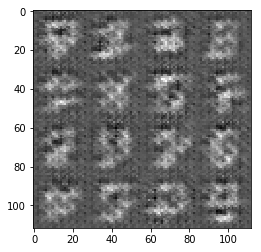

Epoch 0/2... Discriminator loss: 0.4225... Generator loss: 2.5497
Epoch 0/2... Discriminator loss: 0.4713... Generator loss: 3.8945
Epoch 0/2... Discriminator loss: 0.4692... Generator loss: 3.1982
Epoch 0/2... Discriminator loss: 2.3200... Generator loss: 0.2075
Epoch 0/2... Discriminator loss: 2.1234... Generator loss: 0.3729
Epoch 0/2... Discriminator loss: 0.6651... Generator loss: 2.6815
Epoch 0/2... Discriminator loss: 0.5009... Generator loss: 2.2391
Epoch 0/2... Discriminator loss: 0.5847... Generator loss: 2.4103
Epoch 0/2... Discriminator loss: 0.5051... Generator loss: 2.6520
Epoch 0/2... Discriminator loss: 0.3732... Generator loss: 4.7014


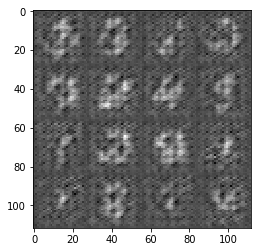

Epoch 0/2... Discriminator loss: 0.3887... Generator loss: 6.9325
Epoch 0/2... Discriminator loss: 0.3743... Generator loss: 5.0526
Epoch 0/2... Discriminator loss: 0.8355... Generator loss: 5.2124
Epoch 0/2... Discriminator loss: 0.3864... Generator loss: 6.5301
Epoch 0/2... Discriminator loss: 0.6119... Generator loss: 2.5795
Epoch 0/2... Discriminator loss: 0.6342... Generator loss: 1.5783
Epoch 0/2... Discriminator loss: 0.3780... Generator loss: 4.0873
Epoch 0/2... Discriminator loss: 0.4377... Generator loss: 3.5404
Epoch 0/2... Discriminator loss: 0.3949... Generator loss: 4.5894
Epoch 0/2... Discriminator loss: 0.5025... Generator loss: 2.5498


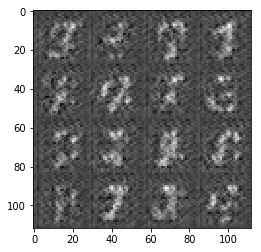

Epoch 0/2... Discriminator loss: 0.3720... Generator loss: 5.6636
Epoch 0/2... Discriminator loss: 0.4724... Generator loss: 2.4218
Epoch 0/2... Discriminator loss: 0.4193... Generator loss: 6.6738
Epoch 0/2... Discriminator loss: 0.6332... Generator loss: 2.3493
Epoch 0/2... Discriminator loss: 0.7092... Generator loss: 1.8931
Epoch 0/2... Discriminator loss: 1.4235... Generator loss: 1.6605
Epoch 0/2... Discriminator loss: 0.5721... Generator loss: 2.1320
Epoch 0/2... Discriminator loss: 0.4155... Generator loss: 4.0416
Epoch 0/2... Discriminator loss: 0.4186... Generator loss: 3.5833
Epoch 0/2... Discriminator loss: 0.7563... Generator loss: 1.6703


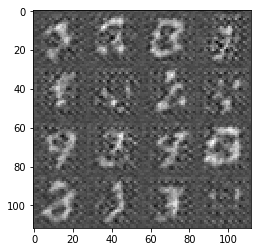

Epoch 0/2... Discriminator loss: 0.9562... Generator loss: 0.9926
Epoch 0/2... Discriminator loss: 0.4565... Generator loss: 2.7478
Epoch 0/2... Discriminator loss: 0.4384... Generator loss: 2.7594
Epoch 0/2... Discriminator loss: 0.4608... Generator loss: 6.1680
Epoch 0/2... Discriminator loss: 0.4699... Generator loss: 4.9466
Epoch 0/2... Discriminator loss: 0.3575... Generator loss: 5.8969
Epoch 0/2... Discriminator loss: 0.5330... Generator loss: 2.6566
Epoch 0/2... Discriminator loss: 1.0074... Generator loss: 0.8392
Epoch 0/2... Discriminator loss: 1.2011... Generator loss: 3.1397
Epoch 0/2... Discriminator loss: 0.5996... Generator loss: 1.5886


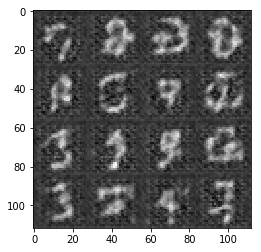

Epoch 0/2... Discriminator loss: 0.8111... Generator loss: 1.1295
Epoch 0/2... Discriminator loss: 0.4569... Generator loss: 3.5977
Epoch 0/2... Discriminator loss: 0.4113... Generator loss: 3.9599
Epoch 0/2... Discriminator loss: 0.4680... Generator loss: 2.6655
Epoch 0/2... Discriminator loss: 0.5185... Generator loss: 2.4353
Epoch 0/2... Discriminator loss: 0.5776... Generator loss: 2.5735
Epoch 0/2... Discriminator loss: 2.8257... Generator loss: 0.1910
Epoch 0/2... Discriminator loss: 0.6471... Generator loss: 3.4226
Epoch 0/2... Discriminator loss: 0.5747... Generator loss: 1.7051
Epoch 0/2... Discriminator loss: 0.4711... Generator loss: 2.8201


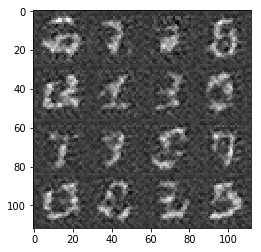

Epoch 0/2... Discriminator loss: 0.4630... Generator loss: 3.4964
Epoch 0/2... Discriminator loss: 0.4044... Generator loss: 4.8876
Epoch 0/2... Discriminator loss: 0.4728... Generator loss: 3.5181
Epoch 0/2... Discriminator loss: 0.3602... Generator loss: 5.3956
Epoch 0/2... Discriminator loss: 0.3922... Generator loss: 3.1083
Epoch 0/2... Discriminator loss: 0.4073... Generator loss: 3.7368
Epoch 0/2... Discriminator loss: 0.3885... Generator loss: 4.9665
Epoch 0/2... Discriminator loss: 0.5140... Generator loss: 2.2074
Epoch 0/2... Discriminator loss: 0.4296... Generator loss: 3.7189
Epoch 0/2... Discriminator loss: 0.3561... Generator loss: 5.8242


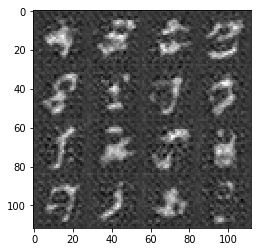

Epoch 0/2... Discriminator loss: 0.4401... Generator loss: 6.8069
Epoch 0/2... Discriminator loss: 0.4285... Generator loss: 3.0774
Epoch 0/2... Discriminator loss: 0.9002... Generator loss: 6.4017
Epoch 0/2... Discriminator loss: 1.0340... Generator loss: 0.9051
Epoch 0/2... Discriminator loss: 0.6030... Generator loss: 2.8142
Epoch 0/2... Discriminator loss: 0.6190... Generator loss: 1.6517
Epoch 0/2... Discriminator loss: 0.4930... Generator loss: 2.4034
Epoch 0/2... Discriminator loss: 0.4367... Generator loss: 2.4675
Epoch 0/2... Discriminator loss: 0.3953... Generator loss: 4.3554
Epoch 0/2... Discriminator loss: 0.6186... Generator loss: 2.8262


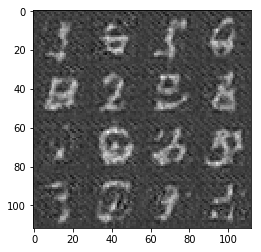

Epoch 0/2... Discriminator loss: 0.7775... Generator loss: 1.6281
Epoch 0/2... Discriminator loss: 0.4650... Generator loss: 3.7477
Epoch 0/2... Discriminator loss: 0.3959... Generator loss: 6.2190
Epoch 0/2... Discriminator loss: 0.3804... Generator loss: 3.6609
Epoch 0/2... Discriminator loss: 0.3610... Generator loss: 7.4683
Epoch 0/2... Discriminator loss: 0.3787... Generator loss: 4.7992
Epoch 0/2... Discriminator loss: 0.5324... Generator loss: 3.0951
Epoch 0/2... Discriminator loss: 0.4816... Generator loss: 2.7666
Epoch 0/2... Discriminator loss: 0.8299... Generator loss: 0.9736
Epoch 0/2... Discriminator loss: 0.5357... Generator loss: 6.1240


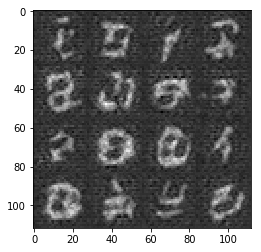

Epoch 0/2... Discriminator loss: 0.4607... Generator loss: 2.4732
Epoch 0/2... Discriminator loss: 0.3774... Generator loss: 4.6784
Epoch 0/2... Discriminator loss: 0.4010... Generator loss: 5.2873
Epoch 0/2... Discriminator loss: 0.5417... Generator loss: 2.8514
Epoch 0/2... Discriminator loss: 0.4167... Generator loss: 2.6825
Epoch 0/2... Discriminator loss: 0.4245... Generator loss: 3.9734
Epoch 0/2... Discriminator loss: 0.4929... Generator loss: 2.7107
Epoch 0/2... Discriminator loss: 0.4218... Generator loss: 3.4985
Epoch 0/2... Discriminator loss: 0.3729... Generator loss: 4.8027
Epoch 0/2... Discriminator loss: 2.8719... Generator loss: 0.1671


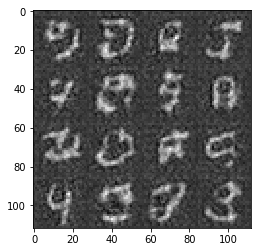

Epoch 0/2... Discriminator loss: 0.5936... Generator loss: 1.8562
Epoch 0/2... Discriminator loss: 0.5338... Generator loss: 2.7370
Epoch 0/2... Discriminator loss: 0.5973... Generator loss: 2.1991
Epoch 0/2... Discriminator loss: 0.4769... Generator loss: 3.9208
Epoch 0/2... Discriminator loss: 0.4950... Generator loss: 2.9642
Epoch 0/2... Discriminator loss: 0.6353... Generator loss: 2.9311
Epoch 0/2... Discriminator loss: 0.4642... Generator loss: 2.1871
Epoch 0/2... Discriminator loss: 0.4559... Generator loss: 3.5731
Epoch 0/2... Discriminator loss: 0.5746... Generator loss: 2.8914
Epoch 0/2... Discriminator loss: 0.3789... Generator loss: 5.3517


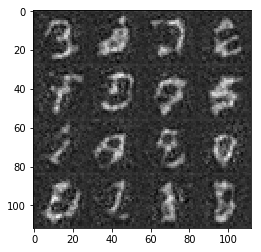

Epoch 0/2... Discriminator loss: 0.4413... Generator loss: 2.8677
Epoch 0/2... Discriminator loss: 0.4468... Generator loss: 5.9708
Epoch 0/2... Discriminator loss: 0.3612... Generator loss: 5.9659
Epoch 0/2... Discriminator loss: 0.3639... Generator loss: 4.7538
Epoch 0/2... Discriminator loss: 0.4341... Generator loss: 4.2500
Epoch 0/2... Discriminator loss: 0.4093... Generator loss: 3.6932
Epoch 0/2... Discriminator loss: 0.7118... Generator loss: 1.0109
Epoch 1/2... Discriminator loss: 0.4838... Generator loss: 3.1896
Epoch 1/2... Discriminator loss: 0.9243... Generator loss: 0.9724
Epoch 1/2... Discriminator loss: 0.7136... Generator loss: 2.1127


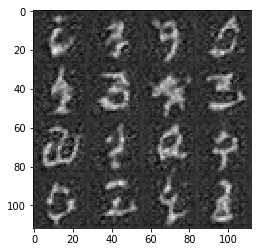

Epoch 1/2... Discriminator loss: 0.5321... Generator loss: 2.3975
Epoch 1/2... Discriminator loss: 0.4339... Generator loss: 3.2309
Epoch 1/2... Discriminator loss: 0.3741... Generator loss: 4.0604
Epoch 1/2... Discriminator loss: 0.4370... Generator loss: 4.0774
Epoch 1/2... Discriminator loss: 0.4761... Generator loss: 2.0226
Epoch 1/2... Discriminator loss: 0.4514... Generator loss: 4.9548
Epoch 1/2... Discriminator loss: 0.3856... Generator loss: 4.7997
Epoch 1/2... Discriminator loss: 0.3680... Generator loss: 7.1590
Epoch 1/2... Discriminator loss: 0.4371... Generator loss: 2.3725
Epoch 1/2... Discriminator loss: 0.3806... Generator loss: 3.9920


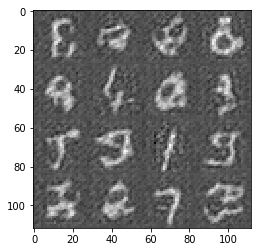

Epoch 1/2... Discriminator loss: 0.5059... Generator loss: 2.3466
Epoch 1/2... Discriminator loss: 0.4534... Generator loss: 3.6300
Epoch 1/2... Discriminator loss: 0.5241... Generator loss: 3.6287
Epoch 1/2... Discriminator loss: 1.7500... Generator loss: 3.7873
Epoch 1/2... Discriminator loss: 0.3754... Generator loss: 6.3624
Epoch 1/2... Discriminator loss: 0.4209... Generator loss: 5.6642
Epoch 1/2... Discriminator loss: 0.4721... Generator loss: 2.2399
Epoch 1/2... Discriminator loss: 0.4453... Generator loss: 3.4585
Epoch 1/2... Discriminator loss: 0.4202... Generator loss: 4.2018
Epoch 1/2... Discriminator loss: 0.4257... Generator loss: 3.2507


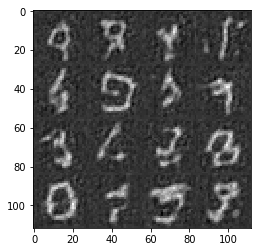

Epoch 1/2... Discriminator loss: 0.7043... Generator loss: 1.7038
Epoch 1/2... Discriminator loss: 0.4461... Generator loss: 3.0416
Epoch 1/2... Discriminator loss: 0.4168... Generator loss: 3.6057
Epoch 1/2... Discriminator loss: 0.3860... Generator loss: 4.3004
Epoch 1/2... Discriminator loss: 0.4597... Generator loss: 3.7012
Epoch 1/2... Discriminator loss: 0.3938... Generator loss: 5.9322
Epoch 1/2... Discriminator loss: 0.3824... Generator loss: 4.6258
Epoch 1/2... Discriminator loss: 0.4210... Generator loss: 4.1446
Epoch 1/2... Discriminator loss: 0.3617... Generator loss: 7.0237
Epoch 1/2... Discriminator loss: 0.3955... Generator loss: 4.0078


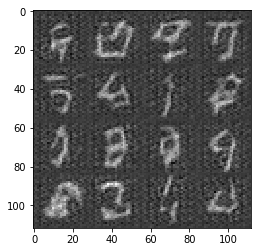

Epoch 1/2... Discriminator loss: 0.4509... Generator loss: 3.0100
Epoch 1/2... Discriminator loss: 0.4140... Generator loss: 4.2870
Epoch 1/2... Discriminator loss: 0.3658... Generator loss: 4.7492
Epoch 1/2... Discriminator loss: 0.3801... Generator loss: 5.0470
Epoch 1/2... Discriminator loss: 0.3740... Generator loss: 4.6809
Epoch 1/2... Discriminator loss: 0.4389... Generator loss: 3.7562
Epoch 1/2... Discriminator loss: 0.4169... Generator loss: 3.8668
Epoch 1/2... Discriminator loss: 1.2145... Generator loss: 6.2841
Epoch 1/2... Discriminator loss: 0.3858... Generator loss: 4.7054
Epoch 1/2... Discriminator loss: 0.3821... Generator loss: 5.4744


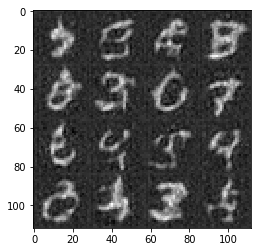

Epoch 1/2... Discriminator loss: 0.4443... Generator loss: 3.3996
Epoch 1/2... Discriminator loss: 0.5888... Generator loss: 3.1468
Epoch 1/2... Discriminator loss: 0.4171... Generator loss: 2.8563
Epoch 1/2... Discriminator loss: 0.5124... Generator loss: 2.7804
Epoch 1/2... Discriminator loss: 0.3738... Generator loss: 4.0654
Epoch 1/2... Discriminator loss: 0.4055... Generator loss: 5.3117
Epoch 1/2... Discriminator loss: 0.5883... Generator loss: 2.6324
Epoch 1/2... Discriminator loss: 0.4196... Generator loss: 2.7000
Epoch 1/2... Discriminator loss: 0.4257... Generator loss: 3.9993
Epoch 1/2... Discriminator loss: 0.8497... Generator loss: 1.8240


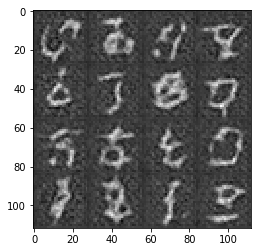

Epoch 1/2... Discriminator loss: 0.7857... Generator loss: 2.6117
Epoch 1/2... Discriminator loss: 0.4158... Generator loss: 2.7601
Epoch 1/2... Discriminator loss: 0.5221... Generator loss: 3.5410
Epoch 1/2... Discriminator loss: 0.4336... Generator loss: 4.1515
Epoch 1/2... Discriminator loss: 0.3944... Generator loss: 3.4334
Epoch 1/2... Discriminator loss: 0.4007... Generator loss: 3.8378
Epoch 1/2... Discriminator loss: 0.4186... Generator loss: 4.8953
Epoch 1/2... Discriminator loss: 0.4373... Generator loss: 3.1876
Epoch 1/2... Discriminator loss: 0.4600... Generator loss: 2.5314
Epoch 1/2... Discriminator loss: 0.4099... Generator loss: 3.3178


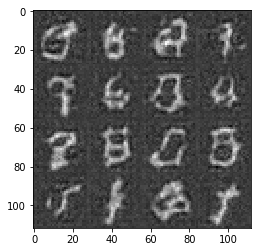

Epoch 1/2... Discriminator loss: 0.3903... Generator loss: 4.0553
Epoch 1/2... Discriminator loss: 0.4283... Generator loss: 4.1396
Epoch 1/2... Discriminator loss: 0.6745... Generator loss: 1.2592
Epoch 1/2... Discriminator loss: 0.4601... Generator loss: 4.2943
Epoch 1/2... Discriminator loss: 0.3779... Generator loss: 6.8727
Epoch 1/2... Discriminator loss: 0.3923... Generator loss: 4.3303
Epoch 1/2... Discriminator loss: 0.4842... Generator loss: 5.5334
Epoch 1/2... Discriminator loss: 0.4536... Generator loss: 3.2386
Epoch 1/2... Discriminator loss: 0.3991... Generator loss: 3.4254
Epoch 1/2... Discriminator loss: 0.3824... Generator loss: 3.7903


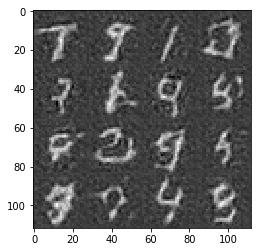

Epoch 1/2... Discriminator loss: 0.4047... Generator loss: 3.7459
Epoch 1/2... Discriminator loss: 0.3833... Generator loss: 6.5042
Epoch 1/2... Discriminator loss: 0.3647... Generator loss: 5.5754
Epoch 1/2... Discriminator loss: 0.5833... Generator loss: 2.9940
Epoch 1/2... Discriminator loss: 0.3767... Generator loss: 4.5019
Epoch 1/2... Discriminator loss: 0.4331... Generator loss: 3.1255
Epoch 1/2... Discriminator loss: 0.4234... Generator loss: 3.1909
Epoch 1/2... Discriminator loss: 0.5609... Generator loss: 3.2594
Epoch 1/2... Discriminator loss: 0.6010... Generator loss: 1.4989
Epoch 1/2... Discriminator loss: 0.4500... Generator loss: 2.9604


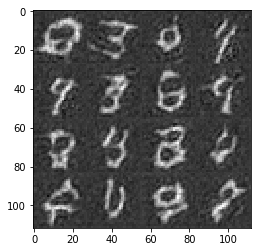

Epoch 1/2... Discriminator loss: 0.3784... Generator loss: 3.9067
Epoch 1/2... Discriminator loss: 0.4649... Generator loss: 3.7717
Epoch 1/2... Discriminator loss: 0.4903... Generator loss: 2.5484
Epoch 1/2... Discriminator loss: 1.0338... Generator loss: 0.9851
Epoch 1/2... Discriminator loss: 1.0261... Generator loss: 4.4413
Epoch 1/2... Discriminator loss: 0.7218... Generator loss: 2.4816
Epoch 1/2... Discriminator loss: 0.5243... Generator loss: 3.0480
Epoch 1/2... Discriminator loss: 0.4003... Generator loss: 3.3243
Epoch 1/2... Discriminator loss: 0.4521... Generator loss: 3.0936
Epoch 1/2... Discriminator loss: 0.4089... Generator loss: 4.6500


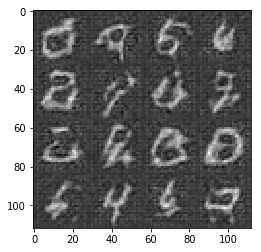

Epoch 1/2... Discriminator loss: 0.4447... Generator loss: 4.5624
Epoch 1/2... Discriminator loss: 0.4105... Generator loss: 4.7835
Epoch 1/2... Discriminator loss: 0.4109... Generator loss: 3.7620
Epoch 1/2... Discriminator loss: 0.4144... Generator loss: 4.0542
Epoch 1/2... Discriminator loss: 0.3829... Generator loss: 3.7479
Epoch 1/2... Discriminator loss: 0.4693... Generator loss: 3.3956
Epoch 1/2... Discriminator loss: 0.3820... Generator loss: 3.2967
Epoch 1/2... Discriminator loss: 0.3524... Generator loss: 11.9961
Epoch 1/2... Discriminator loss: 0.7109... Generator loss: 7.4958
Epoch 1/2... Discriminator loss: 0.3679... Generator loss: 4.1956


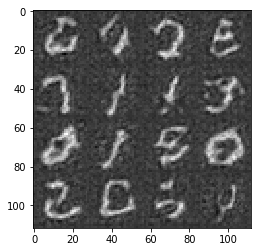

Epoch 1/2... Discriminator loss: 0.4709... Generator loss: 6.6393
Epoch 1/2... Discriminator loss: 0.3955... Generator loss: 4.1352
Epoch 1/2... Discriminator loss: 0.3920... Generator loss: 3.7742
Epoch 1/2... Discriminator loss: 0.4035... Generator loss: 6.0845
Epoch 1/2... Discriminator loss: 0.3611... Generator loss: 5.4957
Epoch 1/2... Discriminator loss: 0.4263... Generator loss: 5.8589
Epoch 1/2... Discriminator loss: 0.4892... Generator loss: 5.0075
Epoch 1/2... Discriminator loss: 0.3768... Generator loss: 4.4784
Epoch 1/2... Discriminator loss: 0.4075... Generator loss: 5.0742
Epoch 1/2... Discriminator loss: 0.4960... Generator loss: 3.4794


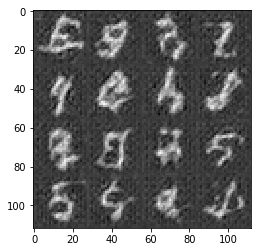

Epoch 1/2... Discriminator loss: 0.6829... Generator loss: 2.4683
Epoch 1/2... Discriminator loss: 0.3841... Generator loss: 3.5719
Epoch 1/2... Discriminator loss: 0.3718... Generator loss: 5.1226
Epoch 1/2... Discriminator loss: 0.5673... Generator loss: 5.6268
Epoch 1/2... Discriminator loss: 0.4257... Generator loss: 3.5741
Epoch 1/2... Discriminator loss: 0.3942... Generator loss: 3.1895
Epoch 1/2... Discriminator loss: 0.3917... Generator loss: 3.4737
Epoch 1/2... Discriminator loss: 0.5300... Generator loss: 3.4643
Epoch 1/2... Discriminator loss: 0.6846... Generator loss: 4.8689
Epoch 1/2... Discriminator loss: 0.6333... Generator loss: 5.7120


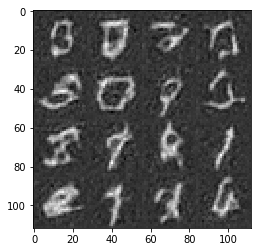

Epoch 1/2... Discriminator loss: 0.3852... Generator loss: 3.0396
Epoch 1/2... Discriminator loss: 0.3799... Generator loss: 4.3608
Epoch 1/2... Discriminator loss: 0.4573... Generator loss: 4.1196
Epoch 1/2... Discriminator loss: 0.4778... Generator loss: 3.5107
Epoch 1/2... Discriminator loss: 0.3887... Generator loss: 4.5374
Epoch 1/2... Discriminator loss: 0.4545... Generator loss: 2.8917
Epoch 1/2... Discriminator loss: 0.3874... Generator loss: 4.9704
Epoch 1/2... Discriminator loss: 0.3534... Generator loss: 7.1366
Epoch 1/2... Discriminator loss: 0.3788... Generator loss: 3.6273
Epoch 1/2... Discriminator loss: 0.6087... Generator loss: 1.4158


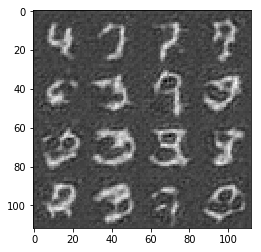

Epoch 1/2... Discriminator loss: 0.6304... Generator loss: 3.5616
Epoch 1/2... Discriminator loss: 0.4215... Generator loss: 5.3229
Epoch 1/2... Discriminator loss: 1.5624... Generator loss: 2.7230
Epoch 1/2... Discriminator loss: 0.5178... Generator loss: 4.2078
Epoch 1/2... Discriminator loss: 0.4241... Generator loss: 5.8397
Epoch 1/2... Discriminator loss: 0.4001... Generator loss: 4.0466
Epoch 1/2... Discriminator loss: 0.5701... Generator loss: 2.1116
Epoch 1/2... Discriminator loss: 0.4565... Generator loss: 3.2246
Epoch 1/2... Discriminator loss: 0.6311... Generator loss: 1.7048
Epoch 1/2... Discriminator loss: 0.5130... Generator loss: 3.4553


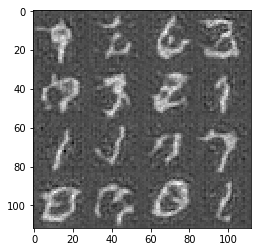

Epoch 1/2... Discriminator loss: 0.3981... Generator loss: 3.2778
Epoch 1/2... Discriminator loss: 0.5118... Generator loss: 2.0064
Epoch 1/2... Discriminator loss: 0.4128... Generator loss: 4.2498
Epoch 1/2... Discriminator loss: 0.4372... Generator loss: 2.7698
Epoch 1/2... Discriminator loss: 0.4737... Generator loss: 3.2358
Epoch 1/2... Discriminator loss: 0.3746... Generator loss: 3.9995
Epoch 1/2... Discriminator loss: 0.4023... Generator loss: 2.9638
Epoch 1/2... Discriminator loss: 0.4807... Generator loss: 4.7973
Epoch 1/2... Discriminator loss: 0.6729... Generator loss: 2.0404
Epoch 1/2... Discriminator loss: 0.4421... Generator loss: 4.6268


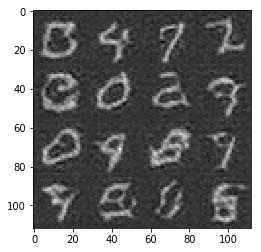

Epoch 1/2... Discriminator loss: 0.5878... Generator loss: 5.2198
Epoch 1/2... Discriminator loss: 0.3815... Generator loss: 4.9294
Epoch 1/2... Discriminator loss: 0.4355... Generator loss: 2.7096
Epoch 1/2... Discriminator loss: 0.4409... Generator loss: 2.0260
Epoch 1/2... Discriminator loss: 0.3773... Generator loss: 4.9159
Epoch 1/2... Discriminator loss: 0.3769... Generator loss: 5.2147
Epoch 1/2... Discriminator loss: 0.4217... Generator loss: 5.0272
Epoch 1/2... Discriminator loss: 0.3838... Generator loss: 3.2081
Epoch 1/2... Discriminator loss: 0.3875... Generator loss: 3.2902
Epoch 1/2... Discriminator loss: 0.4172... Generator loss: 3.7338


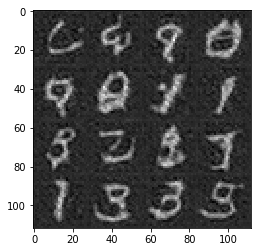

Epoch 1/2... Discriminator loss: 0.4758... Generator loss: 4.3563
Epoch 1/2... Discriminator loss: 0.4214... Generator loss: 5.4180
Epoch 1/2... Discriminator loss: 0.4115... Generator loss: 3.1969
Epoch 1/2... Discriminator loss: 0.6506... Generator loss: 4.4296
Epoch 1/2... Discriminator loss: 0.5838... Generator loss: 2.7585
Epoch 1/2... Discriminator loss: 1.5268... Generator loss: 0.6457
Epoch 1/2... Discriminator loss: 0.8628... Generator loss: 1.9060
Epoch 1/2... Discriminator loss: 0.4459... Generator loss: 2.7329
Epoch 1/2... Discriminator loss: 0.4264... Generator loss: 3.7416
Epoch 1/2... Discriminator loss: 0.5581... Generator loss: 2.5244


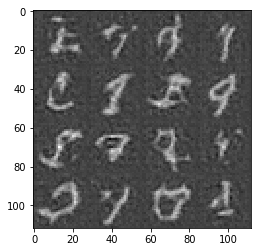

Epoch 1/2... Discriminator loss: 0.4110... Generator loss: 3.2734
Epoch 1/2... Discriminator loss: 0.5257... Generator loss: 3.2087
Epoch 1/2... Discriminator loss: 0.3846... Generator loss: 4.6896
Epoch 1/2... Discriminator loss: 0.7407... Generator loss: 2.3304
Epoch 1/2... Discriminator loss: 0.4313... Generator loss: 5.1649
Epoch 1/2... Discriminator loss: 0.4658... Generator loss: 3.0174
Epoch 1/2... Discriminator loss: 0.7835... Generator loss: 1.1232
Epoch 1/2... Discriminator loss: 0.4182... Generator loss: 3.2179
Epoch 1/2... Discriminator loss: 0.3642... Generator loss: 5.7496
Epoch 1/2... Discriminator loss: 0.4580... Generator loss: 2.1913


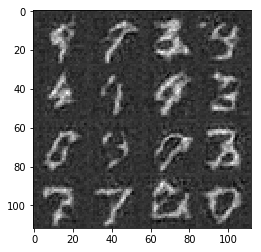

Epoch 1/2... Discriminator loss: 0.4006... Generator loss: 3.4017
Epoch 1/2... Discriminator loss: 0.3809... Generator loss: 4.2960
Epoch 1/2... Discriminator loss: 0.3723... Generator loss: 4.2564
Epoch 1/2... Discriminator loss: 0.3923... Generator loss: 3.8357
Epoch 1/2... Discriminator loss: 0.4629... Generator loss: 2.8677


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/2... Discriminator loss: 1.6222... Generator loss: 0.5737
Epoch 0/2... Discriminator loss: 1.5792... Generator loss: 0.6620
Epoch 0/2... Discriminator loss: 1.2706... Generator loss: 1.0130
Epoch 0/2... Discriminator loss: 1.6262... Generator loss: 0.9862
Epoch 0/2... Discriminator loss: 1.4371... Generator loss: 0.8603
Epoch 0/2... Discriminator loss: 1.4043... Generator loss: 0.7755
Epoch 0/2... Discriminator loss: 1.3739... Generator loss: 0.9589
Epoch 0/2... Discriminator loss: 1.0300... Generator loss: 1.1639
Epoch 0/2... Discriminator loss: 1.1968... Generator loss: 1.0288
Epoch 0/2... Discriminator loss: 1.2172... Generator loss: 1.3522


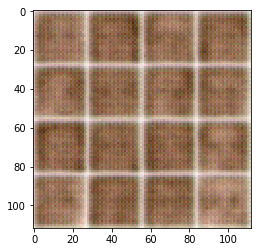

Epoch 0/2... Discriminator loss: 0.8097... Generator loss: 1.6170
Epoch 0/2... Discriminator loss: 0.6817... Generator loss: 1.6249
Epoch 0/2... Discriminator loss: 0.5372... Generator loss: 2.6983
Epoch 0/2... Discriminator loss: 0.5697... Generator loss: 2.3622
Epoch 0/2... Discriminator loss: 0.4151... Generator loss: 3.5980
Epoch 0/2... Discriminator loss: 0.4743... Generator loss: 3.0250
Epoch 0/2... Discriminator loss: 0.4763... Generator loss: 3.3258
Epoch 0/2... Discriminator loss: 0.4073... Generator loss: 4.6281
Epoch 0/2... Discriminator loss: 0.4096... Generator loss: 4.1798
Epoch 0/2... Discriminator loss: 0.4065... Generator loss: 3.4273


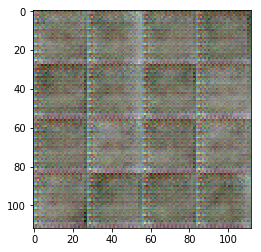

Epoch 0/2... Discriminator loss: 0.3928... Generator loss: 3.9671
Epoch 0/2... Discriminator loss: 0.3962... Generator loss: 4.1596
Epoch 0/2... Discriminator loss: 0.3939... Generator loss: 4.1142
Epoch 0/2... Discriminator loss: 0.4103... Generator loss: 4.1212
Epoch 0/2... Discriminator loss: 0.3621... Generator loss: 4.6645
Epoch 0/2... Discriminator loss: 0.3662... Generator loss: 4.8224
Epoch 0/2... Discriminator loss: 0.3695... Generator loss: 4.7321
Epoch 0/2... Discriminator loss: 0.3992... Generator loss: 4.3559
Epoch 0/2... Discriminator loss: 0.3752... Generator loss: 4.6575
Epoch 0/2... Discriminator loss: 0.3751... Generator loss: 4.3701


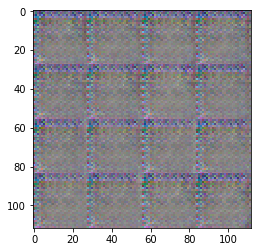

Epoch 0/2... Discriminator loss: 0.3675... Generator loss: 4.8613
Epoch 0/2... Discriminator loss: 0.3577... Generator loss: 4.5212
Epoch 0/2... Discriminator loss: 0.3791... Generator loss: 4.2261
Epoch 0/2... Discriminator loss: 0.3686... Generator loss: 4.2950
Epoch 0/2... Discriminator loss: 0.3787... Generator loss: 4.8432
Epoch 0/2... Discriminator loss: 0.3609... Generator loss: 5.2602
Epoch 0/2... Discriminator loss: 0.3557... Generator loss: 5.1145
Epoch 0/2... Discriminator loss: 0.3608... Generator loss: 5.2750
Epoch 0/2... Discriminator loss: 0.3617... Generator loss: 4.9362
Epoch 0/2... Discriminator loss: 0.3542... Generator loss: 5.0630


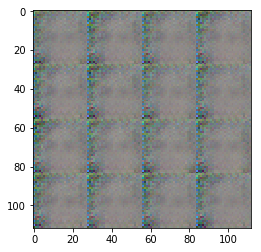

Epoch 0/2... Discriminator loss: 0.3611... Generator loss: 5.1949
Epoch 0/2... Discriminator loss: 0.3614... Generator loss: 5.2409
Epoch 0/2... Discriminator loss: 0.3431... Generator loss: 5.6577
Epoch 0/2... Discriminator loss: 0.3514... Generator loss: 5.4876
Epoch 0/2... Discriminator loss: 0.3576... Generator loss: 4.9273
Epoch 0/2... Discriminator loss: 0.3474... Generator loss: 5.4114
Epoch 0/2... Discriminator loss: 0.3610... Generator loss: 5.4273
Epoch 0/2... Discriminator loss: 0.3584... Generator loss: 5.5626
Epoch 0/2... Discriminator loss: 0.3617... Generator loss: 5.4089
Epoch 0/2... Discriminator loss: 0.3771... Generator loss: 5.0762


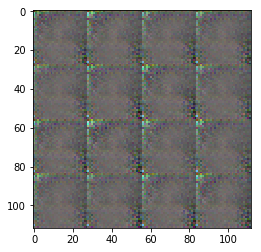

Epoch 0/2... Discriminator loss: 0.3665... Generator loss: 5.1335
Epoch 0/2... Discriminator loss: 0.3515... Generator loss: 5.5902
Epoch 0/2... Discriminator loss: 0.3605... Generator loss: 4.5902
Epoch 0/2... Discriminator loss: 0.3921... Generator loss: 4.0294
Epoch 0/2... Discriminator loss: 0.3555... Generator loss: 4.5655
Epoch 0/2... Discriminator loss: 0.4095... Generator loss: 3.3159
Epoch 0/2... Discriminator loss: 0.4686... Generator loss: 2.9115
Epoch 0/2... Discriminator loss: 0.4892... Generator loss: 3.8265
Epoch 0/2... Discriminator loss: 0.4993... Generator loss: 6.2848
Epoch 0/2... Discriminator loss: 0.4162... Generator loss: 4.7517


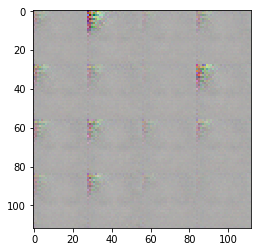

Epoch 0/2... Discriminator loss: 0.3865... Generator loss: 4.9758
Epoch 0/2... Discriminator loss: 0.3973... Generator loss: 5.4060
Epoch 0/2... Discriminator loss: 0.4037... Generator loss: 5.2228
Epoch 0/2... Discriminator loss: 0.3723... Generator loss: 6.1110
Epoch 0/2... Discriminator loss: 0.3736... Generator loss: 6.3045
Epoch 0/2... Discriminator loss: 0.3784... Generator loss: 5.4545
Epoch 0/2... Discriminator loss: 0.4072... Generator loss: 4.5739
Epoch 0/2... Discriminator loss: 0.4135... Generator loss: 4.0584
Epoch 0/2... Discriminator loss: 0.3589... Generator loss: 6.4218
Epoch 0/2... Discriminator loss: 0.3716... Generator loss: 6.3585


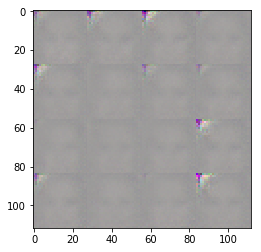

Epoch 0/2... Discriminator loss: 0.5269... Generator loss: 3.2638
Epoch 0/2... Discriminator loss: 0.4062... Generator loss: 3.8004
Epoch 0/2... Discriminator loss: 0.4140... Generator loss: 3.9716
Epoch 0/2... Discriminator loss: 0.7477... Generator loss: 2.0916
Epoch 0/2... Discriminator loss: 0.5223... Generator loss: 2.4253
Epoch 0/2... Discriminator loss: 0.5006... Generator loss: 2.6939
Epoch 0/2... Discriminator loss: 0.3834... Generator loss: 4.1425
Epoch 0/2... Discriminator loss: 0.7505... Generator loss: 8.4162
Epoch 0/2... Discriminator loss: 0.4108... Generator loss: 3.4187
Epoch 0/2... Discriminator loss: 0.3584... Generator loss: 6.9963


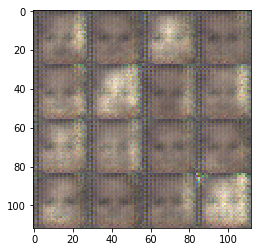

Epoch 0/2... Discriminator loss: 4.3900... Generator loss: 1.9564
Epoch 0/2... Discriminator loss: 1.3889... Generator loss: 1.4880
Epoch 0/2... Discriminator loss: 1.3596... Generator loss: 0.9547
Epoch 0/2... Discriminator loss: 1.4615... Generator loss: 0.9290
Epoch 0/2... Discriminator loss: 1.4407... Generator loss: 1.0649
Epoch 0/2... Discriminator loss: 1.5044... Generator loss: 1.0348
Epoch 0/2... Discriminator loss: 1.4796... Generator loss: 0.6346
Epoch 0/2... Discriminator loss: 1.4428... Generator loss: 0.7941
Epoch 0/2... Discriminator loss: 1.5142... Generator loss: 0.8504
Epoch 0/2... Discriminator loss: 1.5848... Generator loss: 0.7445


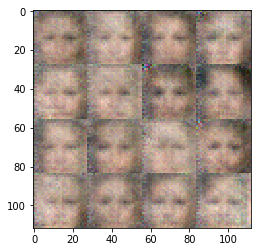

Epoch 0/2... Discriminator loss: 1.4635... Generator loss: 0.8064
Epoch 0/2... Discriminator loss: 1.3628... Generator loss: 1.3061
Epoch 0/2... Discriminator loss: 1.4028... Generator loss: 1.0647
Epoch 0/2... Discriminator loss: 1.5343... Generator loss: 0.8566
Epoch 0/2... Discriminator loss: 1.2598... Generator loss: 1.0948
Epoch 0/2... Discriminator loss: 1.4702... Generator loss: 0.7846
Epoch 0/2... Discriminator loss: 1.0687... Generator loss: 1.2506
Epoch 0/2... Discriminator loss: 1.3611... Generator loss: 1.1179
Epoch 0/2... Discriminator loss: 1.2879... Generator loss: 1.1968
Epoch 0/2... Discriminator loss: 1.3645... Generator loss: 1.0779


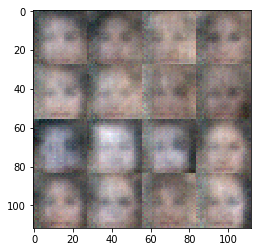

Epoch 0/2... Discriminator loss: 1.3251... Generator loss: 0.9689
Epoch 0/2... Discriminator loss: 1.3355... Generator loss: 0.9449
Epoch 0/2... Discriminator loss: 1.5796... Generator loss: 0.6814
Epoch 0/2... Discriminator loss: 1.3998... Generator loss: 1.2030
Epoch 0/2... Discriminator loss: 1.3785... Generator loss: 1.0463
Epoch 0/2... Discriminator loss: 1.2606... Generator loss: 0.8686
Epoch 0/2... Discriminator loss: 1.2882... Generator loss: 1.1165
Epoch 0/2... Discriminator loss: 1.3317... Generator loss: 0.8432
Epoch 0/2... Discriminator loss: 1.3911... Generator loss: 0.8479
Epoch 0/2... Discriminator loss: 1.3223... Generator loss: 0.7661


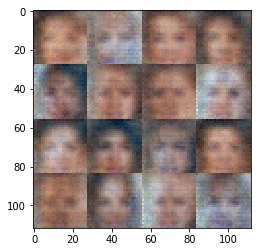

Epoch 0/2... Discriminator loss: 1.3381... Generator loss: 0.9767
Epoch 0/2... Discriminator loss: 1.4882... Generator loss: 1.0162
Epoch 0/2... Discriminator loss: 1.3604... Generator loss: 0.8094
Epoch 0/2... Discriminator loss: 1.2379... Generator loss: 0.8072
Epoch 0/2... Discriminator loss: 1.2505... Generator loss: 1.0428
Epoch 0/2... Discriminator loss: 1.2628... Generator loss: 0.8816
Epoch 0/2... Discriminator loss: 1.2526... Generator loss: 0.8047
Epoch 0/2... Discriminator loss: 1.2983... Generator loss: 0.7495
Epoch 0/2... Discriminator loss: 1.3375... Generator loss: 1.1530
Epoch 0/2... Discriminator loss: 1.1587... Generator loss: 0.8610


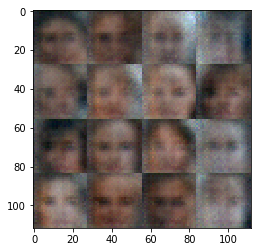

Epoch 0/2... Discriminator loss: 1.4104... Generator loss: 0.7640
Epoch 0/2... Discriminator loss: 1.3697... Generator loss: 0.8999
Epoch 0/2... Discriminator loss: 1.4682... Generator loss: 1.3514
Epoch 0/2... Discriminator loss: 1.3527... Generator loss: 0.7128
Epoch 0/2... Discriminator loss: 1.1668... Generator loss: 1.1859
Epoch 0/2... Discriminator loss: 1.3248... Generator loss: 0.7645
Epoch 0/2... Discriminator loss: 1.4686... Generator loss: 0.9209
Epoch 0/2... Discriminator loss: 1.5570... Generator loss: 0.7396
Epoch 0/2... Discriminator loss: 1.2016... Generator loss: 1.2533
Epoch 0/2... Discriminator loss: 1.1966... Generator loss: 1.0371


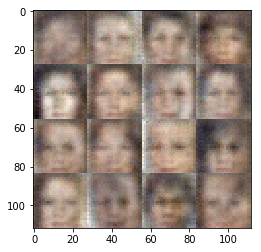

Epoch 0/2... Discriminator loss: 1.3468... Generator loss: 0.9433
Epoch 0/2... Discriminator loss: 1.5384... Generator loss: 0.9204
Epoch 0/2... Discriminator loss: 1.3282... Generator loss: 1.0322
Epoch 0/2... Discriminator loss: 1.2839... Generator loss: 0.9738
Epoch 0/2... Discriminator loss: 1.5869... Generator loss: 0.6542
Epoch 0/2... Discriminator loss: 1.3536... Generator loss: 0.9243
Epoch 0/2... Discriminator loss: 1.2176... Generator loss: 1.3778
Epoch 0/2... Discriminator loss: 1.3591... Generator loss: 1.0333
Epoch 0/2... Discriminator loss: 1.3397... Generator loss: 1.1121
Epoch 0/2... Discriminator loss: 1.3564... Generator loss: 1.2746


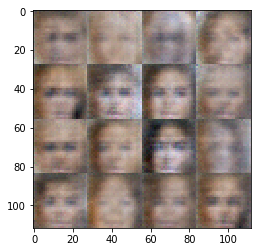

Epoch 0/2... Discriminator loss: 1.2544... Generator loss: 1.0366
Epoch 0/2... Discriminator loss: 1.4510... Generator loss: 0.8028
Epoch 0/2... Discriminator loss: 1.3430... Generator loss: 0.7822
Epoch 0/2... Discriminator loss: 1.3632... Generator loss: 1.0751
Epoch 0/2... Discriminator loss: 1.3192... Generator loss: 1.0518
Epoch 0/2... Discriminator loss: 1.4325... Generator loss: 0.9297
Epoch 0/2... Discriminator loss: 1.3663... Generator loss: 1.0192
Epoch 0/2... Discriminator loss: 1.3108... Generator loss: 0.8991
Epoch 0/2... Discriminator loss: 1.4033... Generator loss: 0.7932
Epoch 0/2... Discriminator loss: 1.3473... Generator loss: 1.0424


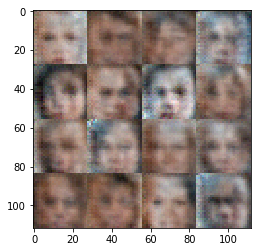

Epoch 0/2... Discriminator loss: 1.2629... Generator loss: 1.0581
Epoch 0/2... Discriminator loss: 1.3389... Generator loss: 0.9046
Epoch 0/2... Discriminator loss: 1.3787... Generator loss: 0.7892
Epoch 0/2... Discriminator loss: 1.3808... Generator loss: 0.9743
Epoch 0/2... Discriminator loss: 1.4068... Generator loss: 1.0639
Epoch 0/2... Discriminator loss: 1.2243... Generator loss: 0.9802
Epoch 0/2... Discriminator loss: 1.3209... Generator loss: 0.9839
Epoch 0/2... Discriminator loss: 1.3124... Generator loss: 1.0155
Epoch 0/2... Discriminator loss: 1.3480... Generator loss: 1.1745
Epoch 0/2... Discriminator loss: 1.3252... Generator loss: 0.6705


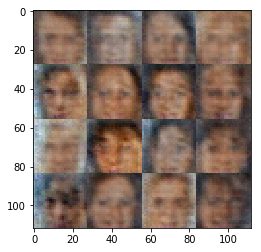

Epoch 0/2... Discriminator loss: 1.6344... Generator loss: 0.6431
Epoch 0/2... Discriminator loss: 1.4564... Generator loss: 0.7738
Epoch 0/2... Discriminator loss: 1.2184... Generator loss: 0.9441
Epoch 0/2... Discriminator loss: 1.3247... Generator loss: 0.8058
Epoch 0/2... Discriminator loss: 1.3755... Generator loss: 0.8010
Epoch 0/2... Discriminator loss: 1.2167... Generator loss: 0.8564
Epoch 0/2... Discriminator loss: 1.2148... Generator loss: 1.1023
Epoch 0/2... Discriminator loss: 1.3597... Generator loss: 0.7995
Epoch 0/2... Discriminator loss: 1.4421... Generator loss: 1.0460
Epoch 0/2... Discriminator loss: 1.5337... Generator loss: 0.7753


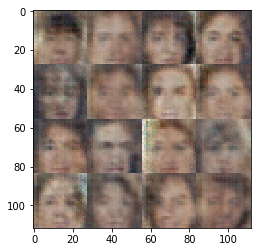

Epoch 0/2... Discriminator loss: 1.3003... Generator loss: 0.7692
Epoch 0/2... Discriminator loss: 1.3279... Generator loss: 0.7761
Epoch 0/2... Discriminator loss: 1.2900... Generator loss: 0.8966
Epoch 0/2... Discriminator loss: 1.3524... Generator loss: 0.7072
Epoch 0/2... Discriminator loss: 1.2396... Generator loss: 0.9943
Epoch 0/2... Discriminator loss: 1.4249... Generator loss: 0.8892
Epoch 0/2... Discriminator loss: 1.1990... Generator loss: 0.9541
Epoch 0/2... Discriminator loss: 1.4854... Generator loss: 0.8294
Epoch 0/2... Discriminator loss: 1.4149... Generator loss: 0.9675
Epoch 0/2... Discriminator loss: 1.3656... Generator loss: 0.9144


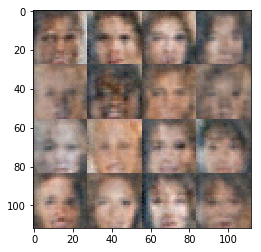

Epoch 0/2... Discriminator loss: 1.3920... Generator loss: 0.8525
Epoch 0/2... Discriminator loss: 1.3104... Generator loss: 0.8002
Epoch 0/2... Discriminator loss: 1.3084... Generator loss: 0.8752
Epoch 0/2... Discriminator loss: 1.2554... Generator loss: 0.7463
Epoch 0/2... Discriminator loss: 1.3585... Generator loss: 0.7803
Epoch 0/2... Discriminator loss: 1.2753... Generator loss: 0.9005
Epoch 0/2... Discriminator loss: 1.2962... Generator loss: 0.7463
Epoch 0/2... Discriminator loss: 1.4221... Generator loss: 0.8482
Epoch 0/2... Discriminator loss: 1.4208... Generator loss: 0.8433
Epoch 0/2... Discriminator loss: 1.2512... Generator loss: 0.8941


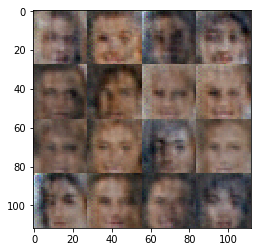

Epoch 0/2... Discriminator loss: 1.4417... Generator loss: 0.8556
Epoch 0/2... Discriminator loss: 1.2670... Generator loss: 1.1276
Epoch 0/2... Discriminator loss: 1.3155... Generator loss: 0.8714
Epoch 0/2... Discriminator loss: 1.4402... Generator loss: 0.7271
Epoch 0/2... Discriminator loss: 1.4132... Generator loss: 0.7203
Epoch 0/2... Discriminator loss: 1.4854... Generator loss: 0.9609
Epoch 0/2... Discriminator loss: 1.2911... Generator loss: 0.9499
Epoch 0/2... Discriminator loss: 1.2737... Generator loss: 0.8415
Epoch 0/2... Discriminator loss: 1.4117... Generator loss: 0.8164
Epoch 0/2... Discriminator loss: 1.5581... Generator loss: 0.8039


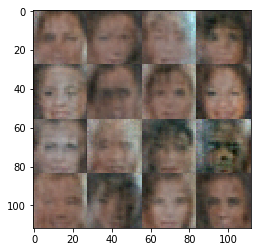

Epoch 0/2... Discriminator loss: 1.4162... Generator loss: 0.8210
Epoch 0/2... Discriminator loss: 1.3940... Generator loss: 0.6905
Epoch 0/2... Discriminator loss: 1.3543... Generator loss: 0.7690
Epoch 0/2... Discriminator loss: 1.3480... Generator loss: 0.7616
Epoch 0/2... Discriminator loss: 1.2841... Generator loss: 0.8085
Epoch 0/2... Discriminator loss: 1.1766... Generator loss: 0.9207
Epoch 0/2... Discriminator loss: 1.4012... Generator loss: 0.8278
Epoch 0/2... Discriminator loss: 1.2765... Generator loss: 0.8434
Epoch 0/2... Discriminator loss: 1.3744... Generator loss: 0.9879
Epoch 0/2... Discriminator loss: 1.4317... Generator loss: 0.9180


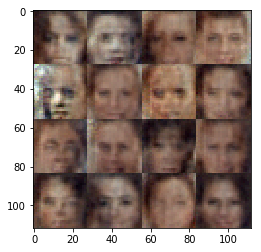

Epoch 0/2... Discriminator loss: 1.4517... Generator loss: 0.7252
Epoch 0/2... Discriminator loss: 1.4107... Generator loss: 0.8307
Epoch 0/2... Discriminator loss: 1.3127... Generator loss: 0.8184
Epoch 0/2... Discriminator loss: 1.4623... Generator loss: 0.7618
Epoch 0/2... Discriminator loss: 1.3152... Generator loss: 0.7766
Epoch 0/2... Discriminator loss: 1.3820... Generator loss: 0.8924
Epoch 0/2... Discriminator loss: 1.3890... Generator loss: 0.8053
Epoch 0/2... Discriminator loss: 1.2668... Generator loss: 0.7184
Epoch 0/2... Discriminator loss: 1.3075... Generator loss: 0.8331
Epoch 0/2... Discriminator loss: 1.3193... Generator loss: 0.8591


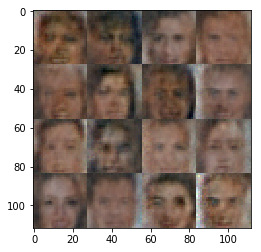

Epoch 0/2... Discriminator loss: 1.4781... Generator loss: 0.8779
Epoch 0/2... Discriminator loss: 1.3582... Generator loss: 0.9071
Epoch 0/2... Discriminator loss: 1.3779... Generator loss: 0.9972
Epoch 0/2... Discriminator loss: 1.3869... Generator loss: 0.8370
Epoch 0/2... Discriminator loss: 1.4315... Generator loss: 0.9696
Epoch 0/2... Discriminator loss: 1.3178... Generator loss: 0.8078
Epoch 0/2... Discriminator loss: 1.3192... Generator loss: 0.7963
Epoch 0/2... Discriminator loss: 1.4318... Generator loss: 0.7694
Epoch 0/2... Discriminator loss: 1.3945... Generator loss: 0.8669
Epoch 0/2... Discriminator loss: 1.4240... Generator loss: 0.8119


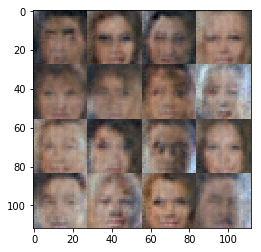

Epoch 0/2... Discriminator loss: 1.3988... Generator loss: 0.9175
Epoch 0/2... Discriminator loss: 1.3791... Generator loss: 0.7400
Epoch 0/2... Discriminator loss: 1.4178... Generator loss: 0.7820
Epoch 0/2... Discriminator loss: 1.3739... Generator loss: 0.9944
Epoch 0/2... Discriminator loss: 1.3584... Generator loss: 0.7912
Epoch 0/2... Discriminator loss: 1.2960... Generator loss: 0.7151
Epoch 0/2... Discriminator loss: 1.2591... Generator loss: 0.8757
Epoch 0/2... Discriminator loss: 1.4433... Generator loss: 0.7968
Epoch 0/2... Discriminator loss: 1.2726... Generator loss: 0.8870
Epoch 0/2... Discriminator loss: 1.1949... Generator loss: 0.8147


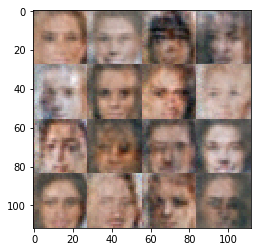

Epoch 0/2... Discriminator loss: 1.3688... Generator loss: 0.8784
Epoch 0/2... Discriminator loss: 1.4007... Generator loss: 0.7990
Epoch 0/2... Discriminator loss: 1.3890... Generator loss: 1.0266
Epoch 0/2... Discriminator loss: 1.3218... Generator loss: 0.8661
Epoch 0/2... Discriminator loss: 1.5494... Generator loss: 0.7012
Epoch 0/2... Discriminator loss: 1.3759... Generator loss: 0.6801
Epoch 0/2... Discriminator loss: 1.1900... Generator loss: 0.7224
Epoch 0/2... Discriminator loss: 1.5017... Generator loss: 0.6721
Epoch 0/2... Discriminator loss: 1.4002... Generator loss: 0.9342
Epoch 0/2... Discriminator loss: 1.3538... Generator loss: 1.0237


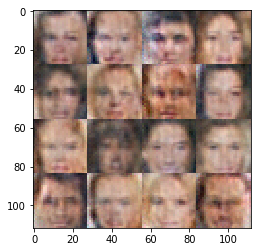

Epoch 0/2... Discriminator loss: 1.3063... Generator loss: 0.7226
Epoch 0/2... Discriminator loss: 1.3733... Generator loss: 0.9160
Epoch 0/2... Discriminator loss: 1.4246... Generator loss: 0.7549
Epoch 0/2... Discriminator loss: 1.4653... Generator loss: 0.8564
Epoch 0/2... Discriminator loss: 1.4027... Generator loss: 0.8161
Epoch 0/2... Discriminator loss: 1.4029... Generator loss: 0.7348
Epoch 0/2... Discriminator loss: 1.2760... Generator loss: 0.8865
Epoch 0/2... Discriminator loss: 1.2387... Generator loss: 0.9395
Epoch 0/2... Discriminator loss: 1.3045... Generator loss: 0.6825
Epoch 0/2... Discriminator loss: 1.4194... Generator loss: 0.8444


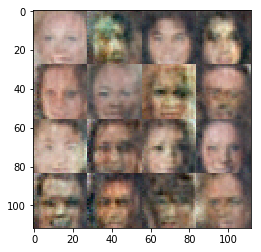

Epoch 0/2... Discriminator loss: 1.3333... Generator loss: 0.8074
Epoch 0/2... Discriminator loss: 1.3218... Generator loss: 0.7000
Epoch 0/2... Discriminator loss: 1.3538... Generator loss: 0.7989
Epoch 0/2... Discriminator loss: 1.4927... Generator loss: 0.6653
Epoch 0/2... Discriminator loss: 1.3409... Generator loss: 0.8329
Epoch 0/2... Discriminator loss: 1.5317... Generator loss: 0.6913
Epoch 0/2... Discriminator loss: 1.3721... Generator loss: 0.8171
Epoch 0/2... Discriminator loss: 1.2514... Generator loss: 0.8871
Epoch 0/2... Discriminator loss: 1.4242... Generator loss: 0.8734
Epoch 0/2... Discriminator loss: 1.4673... Generator loss: 0.7389


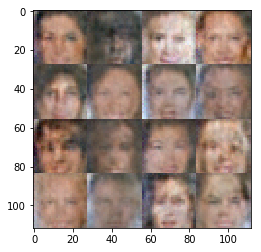

Epoch 0/2... Discriminator loss: 1.3585... Generator loss: 0.9055
Epoch 0/2... Discriminator loss: 1.4645... Generator loss: 0.7285
Epoch 0/2... Discriminator loss: 1.4296... Generator loss: 0.7964
Epoch 0/2... Discriminator loss: 1.3215... Generator loss: 0.9701
Epoch 0/2... Discriminator loss: 1.2009... Generator loss: 0.8275
Epoch 0/2... Discriminator loss: 1.3611... Generator loss: 1.2381
Epoch 0/2... Discriminator loss: 1.2992... Generator loss: 0.9837
Epoch 0/2... Discriminator loss: 1.4082... Generator loss: 0.9069
Epoch 0/2... Discriminator loss: 1.4886... Generator loss: 0.8017
Epoch 0/2... Discriminator loss: 1.3655... Generator loss: 0.8057


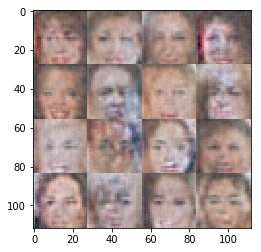

Epoch 0/2... Discriminator loss: 1.2719... Generator loss: 1.0650
Epoch 0/2... Discriminator loss: 1.4555... Generator loss: 0.7574
Epoch 0/2... Discriminator loss: 1.4644... Generator loss: 0.6515
Epoch 0/2... Discriminator loss: 1.4054... Generator loss: 0.7484
Epoch 0/2... Discriminator loss: 1.3276... Generator loss: 0.7039
Epoch 0/2... Discriminator loss: 1.3504... Generator loss: 0.7723
Epoch 0/2... Discriminator loss: 1.3469... Generator loss: 0.8903
Epoch 0/2... Discriminator loss: 1.4419... Generator loss: 0.8096
Epoch 0/2... Discriminator loss: 1.2967... Generator loss: 0.8783
Epoch 0/2... Discriminator loss: 1.3620... Generator loss: 0.9222


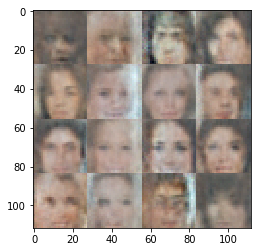

Epoch 0/2... Discriminator loss: 1.3534... Generator loss: 0.8297
Epoch 0/2... Discriminator loss: 1.3269... Generator loss: 0.7814
Epoch 0/2... Discriminator loss: 1.3834... Generator loss: 0.8830
Epoch 0/2... Discriminator loss: 1.4366... Generator loss: 0.7551
Epoch 0/2... Discriminator loss: 1.4001... Generator loss: 0.7871
Epoch 0/2... Discriminator loss: 1.2692... Generator loss: 1.0230
Epoch 0/2... Discriminator loss: 1.3804... Generator loss: 0.7113
Epoch 0/2... Discriminator loss: 1.2843... Generator loss: 0.8172
Epoch 0/2... Discriminator loss: 1.4231... Generator loss: 0.7615
Epoch 0/2... Discriminator loss: 1.3448... Generator loss: 0.7231


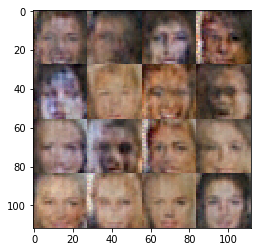

Epoch 0/2... Discriminator loss: 1.4051... Generator loss: 0.7624
Epoch 0/2... Discriminator loss: 1.4123... Generator loss: 0.7647
Epoch 0/2... Discriminator loss: 1.3175... Generator loss: 1.0234
Epoch 0/2... Discriminator loss: 1.4348... Generator loss: 0.6905
Epoch 0/2... Discriminator loss: 1.2838... Generator loss: 0.7323
Epoch 0/2... Discriminator loss: 1.2790... Generator loss: 0.8787
Epoch 0/2... Discriminator loss: 1.2577... Generator loss: 0.8335
Epoch 0/2... Discriminator loss: 1.3194... Generator loss: 0.9566
Epoch 0/2... Discriminator loss: 1.3785... Generator loss: 0.8367
Epoch 0/2... Discriminator loss: 1.3228... Generator loss: 0.8082


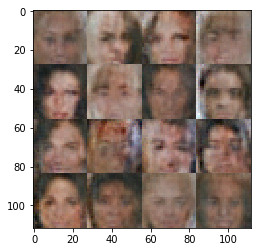

Epoch 0/2... Discriminator loss: 1.3845... Generator loss: 0.8692
Epoch 0/2... Discriminator loss: 1.2728... Generator loss: 0.8165
Epoch 0/2... Discriminator loss: 1.3375... Generator loss: 0.8602
Epoch 0/2... Discriminator loss: 1.3456... Generator loss: 0.9916
Epoch 0/2... Discriminator loss: 1.2815... Generator loss: 0.7991
Epoch 0/2... Discriminator loss: 1.4109... Generator loss: 0.7364
Epoch 0/2... Discriminator loss: 1.4327... Generator loss: 0.8187
Epoch 0/2... Discriminator loss: 1.3319... Generator loss: 0.7120
Epoch 0/2... Discriminator loss: 1.3912... Generator loss: 0.8426
Epoch 0/2... Discriminator loss: 1.2387... Generator loss: 0.8700


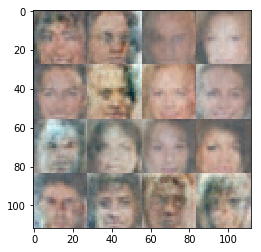

Epoch 0/2... Discriminator loss: 1.2914... Generator loss: 0.9370
Epoch 0/2... Discriminator loss: 1.2511... Generator loss: 1.0380
Epoch 0/2... Discriminator loss: 1.3952... Generator loss: 0.7207
Epoch 0/2... Discriminator loss: 1.3117... Generator loss: 0.8106
Epoch 0/2... Discriminator loss: 1.4376... Generator loss: 0.7527
Epoch 0/2... Discriminator loss: 1.3534... Generator loss: 0.9340
Epoch 0/2... Discriminator loss: 1.3152... Generator loss: 0.7726
Epoch 0/2... Discriminator loss: 1.3256... Generator loss: 0.8125
Epoch 0/2... Discriminator loss: 1.2353... Generator loss: 0.8714
Epoch 0/2... Discriminator loss: 1.3697... Generator loss: 0.9090


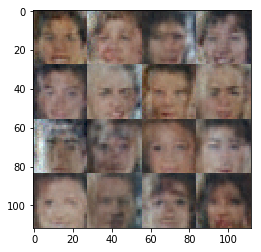

Epoch 0/2... Discriminator loss: 1.3585... Generator loss: 0.6755
Epoch 0/2... Discriminator loss: 1.3069... Generator loss: 0.8816
Epoch 0/2... Discriminator loss: 1.4478... Generator loss: 0.6526
Epoch 0/2... Discriminator loss: 1.3373... Generator loss: 0.8945
Epoch 0/2... Discriminator loss: 1.3996... Generator loss: 0.8655
Epoch 0/2... Discriminator loss: 1.3405... Generator loss: 0.9061
Epoch 0/2... Discriminator loss: 1.3322... Generator loss: 0.8695
Epoch 0/2... Discriminator loss: 1.4227... Generator loss: 0.7697
Epoch 0/2... Discriminator loss: 1.5049... Generator loss: 0.6530
Epoch 0/2... Discriminator loss: 1.4090... Generator loss: 0.8147


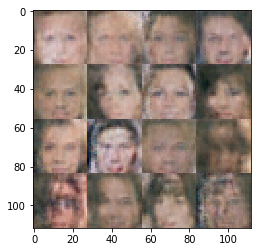

Epoch 0/2... Discriminator loss: 1.3470... Generator loss: 0.7701
Epoch 0/2... Discriminator loss: 1.4153... Generator loss: 0.7549
Epoch 0/2... Discriminator loss: 1.3228... Generator loss: 0.8303
Epoch 0/2... Discriminator loss: 1.4651... Generator loss: 0.6867
Epoch 0/2... Discriminator loss: 1.3779... Generator loss: 0.8028
Epoch 0/2... Discriminator loss: 1.2548... Generator loss: 1.0039
Epoch 0/2... Discriminator loss: 1.3202... Generator loss: 0.8565
Epoch 0/2... Discriminator loss: 1.3433... Generator loss: 0.8078
Epoch 0/2... Discriminator loss: 1.3081... Generator loss: 0.9310
Epoch 0/2... Discriminator loss: 1.2227... Generator loss: 0.8292


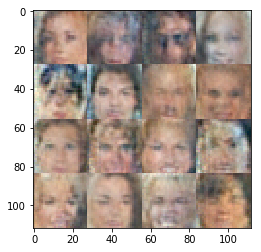

Epoch 0/2... Discriminator loss: 1.3991... Generator loss: 0.7325
Epoch 0/2... Discriminator loss: 1.3178... Generator loss: 0.7939
Epoch 0/2... Discriminator loss: 1.3155... Generator loss: 0.7441
Epoch 0/2... Discriminator loss: 1.2815... Generator loss: 0.9679
Epoch 0/2... Discriminator loss: 1.4331... Generator loss: 0.8274
Epoch 0/2... Discriminator loss: 1.2924... Generator loss: 0.9989
Epoch 0/2... Discriminator loss: 1.4910... Generator loss: 0.7564
Epoch 0/2... Discriminator loss: 1.2781... Generator loss: 0.8469
Epoch 0/2... Discriminator loss: 1.3823... Generator loss: 0.8448
Epoch 0/2... Discriminator loss: 1.4317... Generator loss: 0.8065


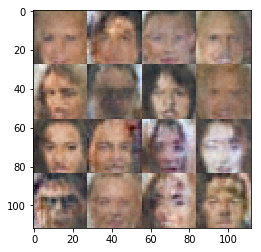

Epoch 0/2... Discriminator loss: 1.3401... Generator loss: 0.8024
Epoch 0/2... Discriminator loss: 1.5209... Generator loss: 0.6937
Epoch 0/2... Discriminator loss: 1.3321... Generator loss: 0.7812
Epoch 0/2... Discriminator loss: 1.4702... Generator loss: 0.6454
Epoch 0/2... Discriminator loss: 1.4420... Generator loss: 0.8070
Epoch 0/2... Discriminator loss: 1.4052... Generator loss: 0.8147
Epoch 0/2... Discriminator loss: 1.3288... Generator loss: 0.8721
Epoch 0/2... Discriminator loss: 1.3784... Generator loss: 0.9012
Epoch 0/2... Discriminator loss: 1.4923... Generator loss: 0.6430
Epoch 0/2... Discriminator loss: 1.3641... Generator loss: 0.7738


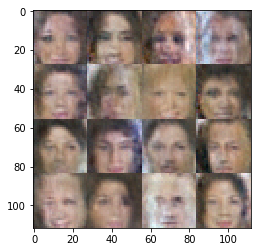

Epoch 0/2... Discriminator loss: 1.3114... Generator loss: 0.8402
Epoch 0/2... Discriminator loss: 1.2563... Generator loss: 0.8300
Epoch 0/2... Discriminator loss: 1.3360... Generator loss: 0.8009
Epoch 0/2... Discriminator loss: 1.3349... Generator loss: 0.8966
Epoch 0/2... Discriminator loss: 1.3672... Generator loss: 0.7507
Epoch 0/2... Discriminator loss: 1.3538... Generator loss: 0.8426
Epoch 0/2... Discriminator loss: 1.4119... Generator loss: 0.6748
Epoch 0/2... Discriminator loss: 1.4959... Generator loss: 0.7988
Epoch 0/2... Discriminator loss: 1.3392... Generator loss: 0.6979
Epoch 0/2... Discriminator loss: 1.3255... Generator loss: 0.8562


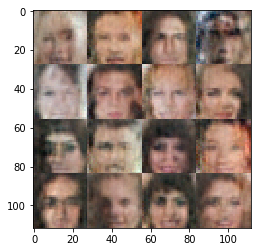

Epoch 0/2... Discriminator loss: 1.5793... Generator loss: 0.6951
Epoch 0/2... Discriminator loss: 1.3709... Generator loss: 0.7478
Epoch 0/2... Discriminator loss: 1.3436... Generator loss: 0.8343
Epoch 0/2... Discriminator loss: 1.4043... Generator loss: 0.7291
Epoch 0/2... Discriminator loss: 1.3260... Generator loss: 0.9253
Epoch 0/2... Discriminator loss: 1.3035... Generator loss: 0.7679
Epoch 0/2... Discriminator loss: 1.5376... Generator loss: 0.6524
Epoch 0/2... Discriminator loss: 1.3851... Generator loss: 0.7561
Epoch 0/2... Discriminator loss: 1.3047... Generator loss: 0.8207
Epoch 0/2... Discriminator loss: 1.4344... Generator loss: 0.7834


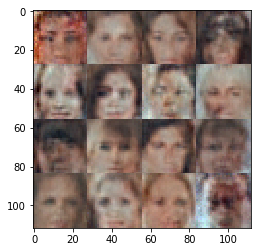

Epoch 0/2... Discriminator loss: 1.3592... Generator loss: 0.8150
Epoch 0/2... Discriminator loss: 1.3851... Generator loss: 0.7289
Epoch 0/2... Discriminator loss: 1.4579... Generator loss: 0.8514
Epoch 0/2... Discriminator loss: 1.3160... Generator loss: 0.7951
Epoch 0/2... Discriminator loss: 1.3450... Generator loss: 0.8805
Epoch 0/2... Discriminator loss: 1.4005... Generator loss: 0.8418
Epoch 0/2... Discriminator loss: 1.3430... Generator loss: 0.7710
Epoch 0/2... Discriminator loss: 1.2862... Generator loss: 0.8185
Epoch 0/2... Discriminator loss: 1.5012... Generator loss: 0.8092
Epoch 0/2... Discriminator loss: 1.2911... Generator loss: 0.8619


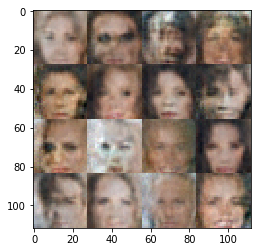

Epoch 0/2... Discriminator loss: 1.4093... Generator loss: 0.8115
Epoch 0/2... Discriminator loss: 1.3224... Generator loss: 0.8581
Epoch 0/2... Discriminator loss: 1.5767... Generator loss: 0.5796
Epoch 0/2... Discriminator loss: 1.3838... Generator loss: 0.7904
Epoch 0/2... Discriminator loss: 1.3518... Generator loss: 0.7805
Epoch 0/2... Discriminator loss: 1.2874... Generator loss: 0.9318
Epoch 0/2... Discriminator loss: 1.4665... Generator loss: 0.7046
Epoch 0/2... Discriminator loss: 1.3959... Generator loss: 0.7209
Epoch 0/2... Discriminator loss: 1.3852... Generator loss: 0.6867
Epoch 0/2... Discriminator loss: 1.3698... Generator loss: 0.8890


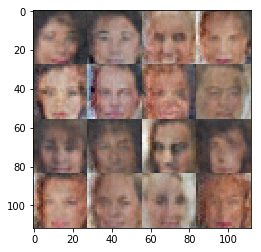

Epoch 0/2... Discriminator loss: 1.3617... Generator loss: 0.8233
Epoch 0/2... Discriminator loss: 1.4254... Generator loss: 0.8770
Epoch 0/2... Discriminator loss: 1.3148... Generator loss: 0.8824
Epoch 0/2... Discriminator loss: 1.3698... Generator loss: 0.7868
Epoch 0/2... Discriminator loss: 1.3932... Generator loss: 0.6923
Epoch 0/2... Discriminator loss: 1.3555... Generator loss: 0.9202
Epoch 0/2... Discriminator loss: 1.2900... Generator loss: 0.8816
Epoch 0/2... Discriminator loss: 1.5130... Generator loss: 0.5496
Epoch 0/2... Discriminator loss: 1.3423... Generator loss: 0.8033
Epoch 0/2... Discriminator loss: 1.3664... Generator loss: 0.7064


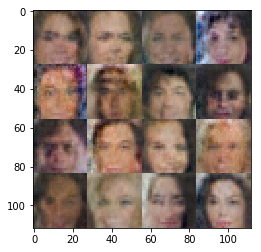

Epoch 0/2... Discriminator loss: 1.3840... Generator loss: 0.7877
Epoch 0/2... Discriminator loss: 1.3651... Generator loss: 0.7767
Epoch 0/2... Discriminator loss: 1.2913... Generator loss: 0.8402
Epoch 0/2... Discriminator loss: 1.2640... Generator loss: 0.9045
Epoch 0/2... Discriminator loss: 1.3527... Generator loss: 0.8258
Epoch 0/2... Discriminator loss: 1.2502... Generator loss: 0.8260
Epoch 0/2... Discriminator loss: 1.3462... Generator loss: 0.8442
Epoch 0/2... Discriminator loss: 1.3883... Generator loss: 0.8258
Epoch 0/2... Discriminator loss: 1.3075... Generator loss: 0.7815
Epoch 0/2... Discriminator loss: 1.2661... Generator loss: 0.8989


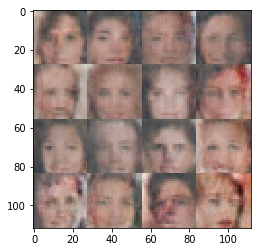

Epoch 0/2... Discriminator loss: 1.4071... Generator loss: 0.8491
Epoch 0/2... Discriminator loss: 1.2965... Generator loss: 0.7549
Epoch 0/2... Discriminator loss: 1.2246... Generator loss: 0.9716
Epoch 0/2... Discriminator loss: 1.3502... Generator loss: 0.8028
Epoch 0/2... Discriminator loss: 1.4089... Generator loss: 0.7905
Epoch 0/2... Discriminator loss: 1.3444... Generator loss: 0.7634
Epoch 0/2... Discriminator loss: 1.4410... Generator loss: 0.6710
Epoch 0/2... Discriminator loss: 1.3491... Generator loss: 0.9111
Epoch 0/2... Discriminator loss: 1.4164... Generator loss: 0.7886
Epoch 0/2... Discriminator loss: 1.4496... Generator loss: 0.6435


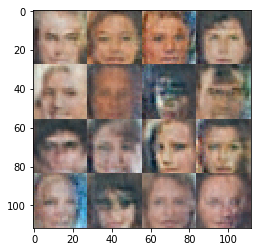

Epoch 0/2... Discriminator loss: 1.3827... Generator loss: 0.8947
Epoch 0/2... Discriminator loss: 1.2490... Generator loss: 0.8408
Epoch 0/2... Discriminator loss: 1.3883... Generator loss: 0.8618
Epoch 0/2... Discriminator loss: 1.3374... Generator loss: 0.8025
Epoch 0/2... Discriminator loss: 1.4127... Generator loss: 0.7229
Epoch 0/2... Discriminator loss: 1.3992... Generator loss: 0.8017
Epoch 0/2... Discriminator loss: 1.3257... Generator loss: 0.7485
Epoch 0/2... Discriminator loss: 1.4611... Generator loss: 0.8228
Epoch 0/2... Discriminator loss: 1.4004... Generator loss: 0.7048
Epoch 0/2... Discriminator loss: 1.3648... Generator loss: 0.7582


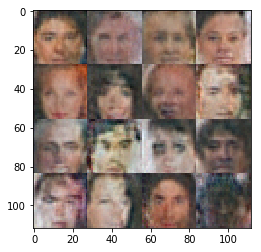

Epoch 0/2... Discriminator loss: 1.2748... Generator loss: 0.7677
Epoch 0/2... Discriminator loss: 1.4372... Generator loss: 0.7274
Epoch 0/2... Discriminator loss: 1.4089... Generator loss: 0.7782
Epoch 0/2... Discriminator loss: 1.3224... Generator loss: 0.8436
Epoch 0/2... Discriminator loss: 1.4033... Generator loss: 0.7816
Epoch 0/2... Discriminator loss: 1.4516... Generator loss: 0.7608
Epoch 0/2... Discriminator loss: 1.3606... Generator loss: 0.8361
Epoch 0/2... Discriminator loss: 1.2946... Generator loss: 0.7508
Epoch 0/2... Discriminator loss: 1.3694... Generator loss: 0.8220
Epoch 0/2... Discriminator loss: 1.3698... Generator loss: 0.7798


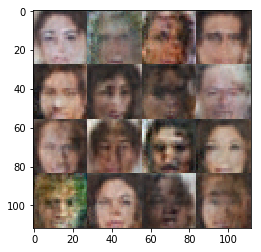

Epoch 0/2... Discriminator loss: 1.3491... Generator loss: 0.8473
Epoch 0/2... Discriminator loss: 1.2958... Generator loss: 1.0260
Epoch 0/2... Discriminator loss: 1.3521... Generator loss: 0.7951
Epoch 0/2... Discriminator loss: 1.2746... Generator loss: 0.8521
Epoch 0/2... Discriminator loss: 1.4212... Generator loss: 0.7289
Epoch 0/2... Discriminator loss: 1.4304... Generator loss: 0.7934
Epoch 0/2... Discriminator loss: 1.2398... Generator loss: 0.7801
Epoch 0/2... Discriminator loss: 1.4076... Generator loss: 0.7861
Epoch 0/2... Discriminator loss: 1.3756... Generator loss: 0.6649
Epoch 0/2... Discriminator loss: 1.3454... Generator loss: 0.6807


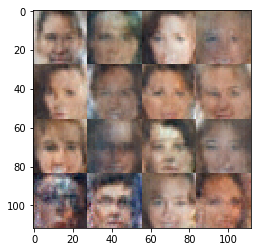

Epoch 0/2... Discriminator loss: 1.4182... Generator loss: 0.8108
Epoch 0/2... Discriminator loss: 1.3039... Generator loss: 0.8645
Epoch 0/2... Discriminator loss: 1.3949... Generator loss: 0.7750
Epoch 0/2... Discriminator loss: 1.4347... Generator loss: 0.7475
Epoch 0/2... Discriminator loss: 1.3930... Generator loss: 0.8349
Epoch 0/2... Discriminator loss: 1.3352... Generator loss: 0.8766
Epoch 0/2... Discriminator loss: 1.3591... Generator loss: 0.7688
Epoch 0/2... Discriminator loss: 1.4127... Generator loss: 0.9354
Epoch 0/2... Discriminator loss: 1.3150... Generator loss: 0.8343
Epoch 0/2... Discriminator loss: 1.2493... Generator loss: 0.9132


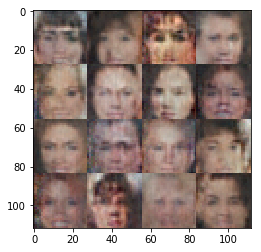

Epoch 0/2... Discriminator loss: 1.3318... Generator loss: 0.8874
Epoch 0/2... Discriminator loss: 1.4200... Generator loss: 0.7743
Epoch 0/2... Discriminator loss: 1.2940... Generator loss: 0.7893
Epoch 0/2... Discriminator loss: 1.3943... Generator loss: 0.8198
Epoch 0/2... Discriminator loss: 1.3245... Generator loss: 0.8236
Epoch 0/2... Discriminator loss: 1.3528... Generator loss: 0.8450
Epoch 0/2... Discriminator loss: 1.3330... Generator loss: 0.7335
Epoch 0/2... Discriminator loss: 1.2909... Generator loss: 0.9443
Epoch 0/2... Discriminator loss: 1.3141... Generator loss: 0.8399
Epoch 0/2... Discriminator loss: 1.3463... Generator loss: 0.8268


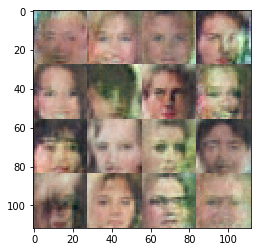

Epoch 0/2... Discriminator loss: 1.4624... Generator loss: 0.7428
Epoch 0/2... Discriminator loss: 1.2899... Generator loss: 1.0226
Epoch 0/2... Discriminator loss: 1.3495... Generator loss: 0.7836
Epoch 0/2... Discriminator loss: 1.3290... Generator loss: 0.7992
Epoch 0/2... Discriminator loss: 1.3929... Generator loss: 0.8361
Epoch 0/2... Discriminator loss: 1.2942... Generator loss: 0.8569
Epoch 0/2... Discriminator loss: 1.3254... Generator loss: 0.8507
Epoch 0/2... Discriminator loss: 1.3664... Generator loss: 0.8166
Epoch 0/2... Discriminator loss: 1.3721... Generator loss: 0.7753
Epoch 0/2... Discriminator loss: 1.2795... Generator loss: 0.8649


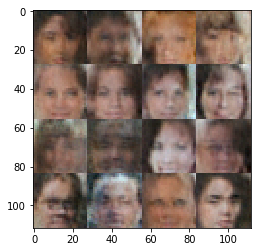

Epoch 0/2... Discriminator loss: 1.3934... Generator loss: 0.8000
Epoch 0/2... Discriminator loss: 1.3021... Generator loss: 0.7794
Epoch 0/2... Discriminator loss: 1.3543... Generator loss: 0.8431
Epoch 0/2... Discriminator loss: 1.3305... Generator loss: 0.9309
Epoch 0/2... Discriminator loss: 1.3250... Generator loss: 0.8385
Epoch 0/2... Discriminator loss: 1.4181... Generator loss: 0.7688
Epoch 0/2... Discriminator loss: 1.4871... Generator loss: 0.7232
Epoch 0/2... Discriminator loss: 1.3976... Generator loss: 0.8177
Epoch 0/2... Discriminator loss: 1.3640... Generator loss: 0.8153
Epoch 0/2... Discriminator loss: 1.3792... Generator loss: 0.8762


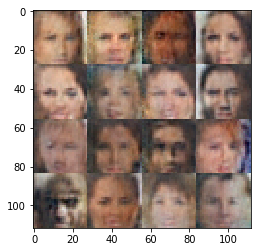

Epoch 0/2... Discriminator loss: 1.4402... Generator loss: 0.7427
Epoch 0/2... Discriminator loss: 1.3615... Generator loss: 0.7849
Epoch 0/2... Discriminator loss: 1.3501... Generator loss: 0.7699
Epoch 0/2... Discriminator loss: 1.4694... Generator loss: 0.6184
Epoch 0/2... Discriminator loss: 1.3049... Generator loss: 0.9875
Epoch 0/2... Discriminator loss: 1.3656... Generator loss: 0.8515
Epoch 0/2... Discriminator loss: 1.3594... Generator loss: 0.7717
Epoch 0/2... Discriminator loss: 1.3077... Generator loss: 0.9092
Epoch 0/2... Discriminator loss: 1.4144... Generator loss: 0.8036
Epoch 0/2... Discriminator loss: 1.4126... Generator loss: 0.6817


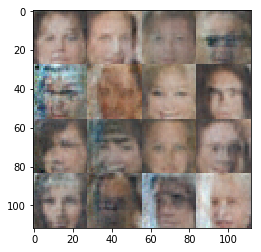

Epoch 0/2... Discriminator loss: 1.3991... Generator loss: 0.7752
Epoch 0/2... Discriminator loss: 1.3864... Generator loss: 0.8400
Epoch 0/2... Discriminator loss: 1.2730... Generator loss: 0.8758
Epoch 0/2... Discriminator loss: 1.3795... Generator loss: 0.7582
Epoch 0/2... Discriminator loss: 1.4756... Generator loss: 0.8542
Epoch 0/2... Discriminator loss: 1.5062... Generator loss: 0.6794
Epoch 0/2... Discriminator loss: 1.4373... Generator loss: 0.7746
Epoch 0/2... Discriminator loss: 1.4098... Generator loss: 0.7133
Epoch 0/2... Discriminator loss: 1.3844... Generator loss: 0.8123
Epoch 0/2... Discriminator loss: 1.4022... Generator loss: 1.0077


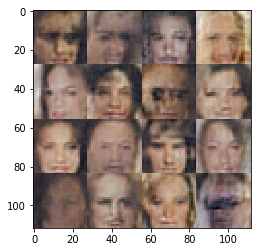

Epoch 0/2... Discriminator loss: 1.2987... Generator loss: 0.7400
Epoch 0/2... Discriminator loss: 1.4264... Generator loss: 0.7089
Epoch 0/2... Discriminator loss: 1.3916... Generator loss: 0.6870
Epoch 0/2... Discriminator loss: 1.3528... Generator loss: 0.7727
Epoch 0/2... Discriminator loss: 1.3886... Generator loss: 0.9195
Epoch 0/2... Discriminator loss: 1.3630... Generator loss: 0.8236
Epoch 0/2... Discriminator loss: 1.4393... Generator loss: 0.8091
Epoch 0/2... Discriminator loss: 1.2866... Generator loss: 0.8864
Epoch 0/2... Discriminator loss: 1.3081... Generator loss: 0.9014
Epoch 0/2... Discriminator loss: 1.3636... Generator loss: 0.7436


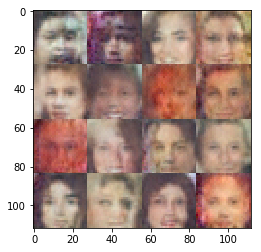

Epoch 0/2... Discriminator loss: 1.3201... Generator loss: 0.8176
Epoch 0/2... Discriminator loss: 1.4412... Generator loss: 0.7649
Epoch 0/2... Discriminator loss: 1.3544... Generator loss: 0.6869
Epoch 0/2... Discriminator loss: 1.3102... Generator loss: 0.8351
Epoch 0/2... Discriminator loss: 1.4427... Generator loss: 0.7697
Epoch 0/2... Discriminator loss: 1.3541... Generator loss: 0.7715
Epoch 0/2... Discriminator loss: 1.4120... Generator loss: 0.7134
Epoch 0/2... Discriminator loss: 1.4145... Generator loss: 0.6797
Epoch 0/2... Discriminator loss: 1.3339... Generator loss: 0.8393
Epoch 0/2... Discriminator loss: 1.3195... Generator loss: 0.8039


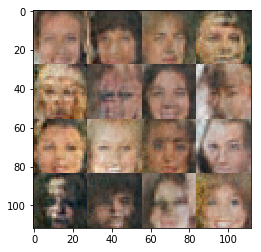

Epoch 0/2... Discriminator loss: 1.3726... Generator loss: 0.8387
Epoch 0/2... Discriminator loss: 1.3643... Generator loss: 0.7313
Epoch 0/2... Discriminator loss: 1.4160... Generator loss: 0.8733
Epoch 0/2... Discriminator loss: 1.3932... Generator loss: 0.8068
Epoch 0/2... Discriminator loss: 1.3930... Generator loss: 0.7359
Epoch 0/2... Discriminator loss: 1.3652... Generator loss: 0.7808
Epoch 0/2... Discriminator loss: 1.3140... Generator loss: 0.8701
Epoch 0/2... Discriminator loss: 1.3860... Generator loss: 0.7359
Epoch 0/2... Discriminator loss: 1.3674... Generator loss: 0.8492
Epoch 0/2... Discriminator loss: 1.3094... Generator loss: 0.8203


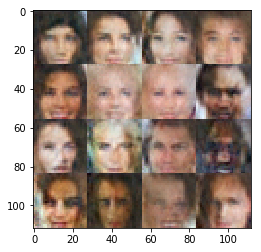

Epoch 0/2... Discriminator loss: 1.4084... Generator loss: 0.8802
Epoch 0/2... Discriminator loss: 1.4015... Generator loss: 0.7957
Epoch 0/2... Discriminator loss: 1.3306... Generator loss: 0.8605
Epoch 0/2... Discriminator loss: 1.3835... Generator loss: 0.7704
Epoch 0/2... Discriminator loss: 1.3493... Generator loss: 0.8669
Epoch 0/2... Discriminator loss: 1.3399... Generator loss: 0.8730
Epoch 0/2... Discriminator loss: 1.3665... Generator loss: 0.7488
Epoch 0/2... Discriminator loss: 1.3757... Generator loss: 0.7205
Epoch 0/2... Discriminator loss: 1.3398... Generator loss: 0.7895
Epoch 0/2... Discriminator loss: 1.2782... Generator loss: 0.7791


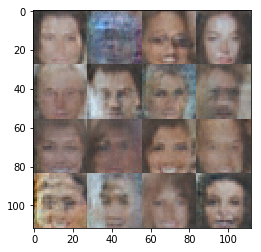

Epoch 0/2... Discriminator loss: 1.4895... Generator loss: 0.7015
Epoch 0/2... Discriminator loss: 1.4782... Generator loss: 0.7852
Epoch 0/2... Discriminator loss: 1.3984... Generator loss: 0.7175
Epoch 0/2... Discriminator loss: 1.3579... Generator loss: 0.8821
Epoch 0/2... Discriminator loss: 1.3563... Generator loss: 0.7607
Epoch 0/2... Discriminator loss: 1.2284... Generator loss: 0.8959
Epoch 0/2... Discriminator loss: 1.3505... Generator loss: 0.7740
Epoch 0/2... Discriminator loss: 1.2942... Generator loss: 0.7871
Epoch 0/2... Discriminator loss: 1.1883... Generator loss: 0.9671
Epoch 0/2... Discriminator loss: 1.3281... Generator loss: 0.9237


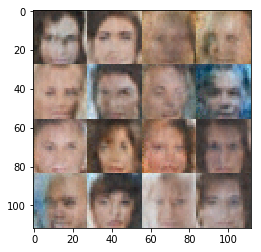

Epoch 0/2... Discriminator loss: 1.3854... Generator loss: 0.7747
Epoch 0/2... Discriminator loss: 1.3406... Generator loss: 0.7123
Epoch 0/2... Discriminator loss: 1.3595... Generator loss: 0.7981
Epoch 0/2... Discriminator loss: 1.3160... Generator loss: 0.8740
Epoch 0/2... Discriminator loss: 1.4205... Generator loss: 0.8378
Epoch 0/2... Discriminator loss: 1.3986... Generator loss: 0.7676
Epoch 0/2... Discriminator loss: 1.2610... Generator loss: 0.8241
Epoch 0/2... Discriminator loss: 1.2540... Generator loss: 0.8413
Epoch 0/2... Discriminator loss: 1.3743... Generator loss: 0.7979
Epoch 0/2... Discriminator loss: 1.3181... Generator loss: 0.8579


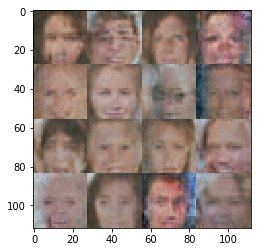

Epoch 0/2... Discriminator loss: 1.3595... Generator loss: 0.8336
Epoch 0/2... Discriminator loss: 1.4298... Generator loss: 0.7922
Epoch 0/2... Discriminator loss: 1.3853... Generator loss: 0.7801
Epoch 0/2... Discriminator loss: 1.3562... Generator loss: 0.8499
Epoch 0/2... Discriminator loss: 1.3866... Generator loss: 0.8840
Epoch 0/2... Discriminator loss: 1.4165... Generator loss: 0.7138
Epoch 0/2... Discriminator loss: 1.4004... Generator loss: 0.8666
Epoch 0/2... Discriminator loss: 1.4463... Generator loss: 0.6514
Epoch 0/2... Discriminator loss: 1.3226... Generator loss: 0.8080
Epoch 0/2... Discriminator loss: 1.3288... Generator loss: 0.8570


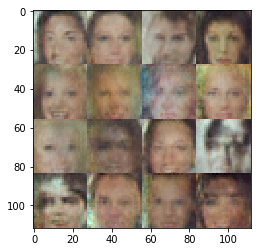

Epoch 0/2... Discriminator loss: 1.3895... Generator loss: 0.9184
Epoch 0/2... Discriminator loss: 1.2350... Generator loss: 0.8296
Epoch 0/2... Discriminator loss: 1.3162... Generator loss: 0.8040
Epoch 0/2... Discriminator loss: 1.3014... Generator loss: 0.7885
Epoch 0/2... Discriminator loss: 1.3102... Generator loss: 0.8484
Epoch 0/2... Discriminator loss: 1.4414... Generator loss: 0.7009
Epoch 0/2... Discriminator loss: 1.4035... Generator loss: 0.7834
Epoch 0/2... Discriminator loss: 1.3896... Generator loss: 0.7491
Epoch 0/2... Discriminator loss: 1.3750... Generator loss: 0.8110
Epoch 0/2... Discriminator loss: 1.3559... Generator loss: 0.8991


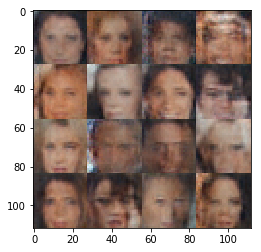

Epoch 0/2... Discriminator loss: 1.3544... Generator loss: 0.7426
Epoch 0/2... Discriminator loss: 1.4882... Generator loss: 0.7102
Epoch 0/2... Discriminator loss: 1.3059... Generator loss: 0.8530
Epoch 0/2... Discriminator loss: 1.4328... Generator loss: 0.8506
Epoch 0/2... Discriminator loss: 1.3453... Generator loss: 0.7828
Epoch 0/2... Discriminator loss: 1.3635... Generator loss: 0.7509
Epoch 0/2... Discriminator loss: 1.4141... Generator loss: 0.7491
Epoch 0/2... Discriminator loss: 1.4704... Generator loss: 0.7589
Epoch 0/2... Discriminator loss: 1.3870... Generator loss: 0.8252
Epoch 0/2... Discriminator loss: 1.3192... Generator loss: 0.8698


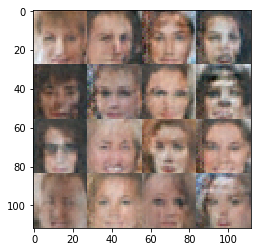

Epoch 0/2... Discriminator loss: 1.3849... Generator loss: 0.8411
Epoch 0/2... Discriminator loss: 1.3099... Generator loss: 0.7916
Epoch 0/2... Discriminator loss: 1.3429... Generator loss: 0.7694
Epoch 0/2... Discriminator loss: 1.3844... Generator loss: 0.7875
Epoch 0/2... Discriminator loss: 1.3774... Generator loss: 0.8882
Epoch 0/2... Discriminator loss: 1.3578... Generator loss: 0.7796
Epoch 0/2... Discriminator loss: 1.4061... Generator loss: 0.7628
Epoch 0/2... Discriminator loss: 1.3677... Generator loss: 0.8011
Epoch 0/2... Discriminator loss: 1.3573... Generator loss: 0.8893
Epoch 0/2... Discriminator loss: 1.4450... Generator loss: 0.8372


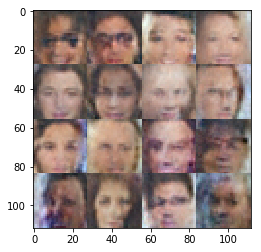

Epoch 0/2... Discriminator loss: 1.3343... Generator loss: 0.9494
Epoch 0/2... Discriminator loss: 1.4145... Generator loss: 0.8282
Epoch 0/2... Discriminator loss: 1.3837... Generator loss: 0.8457
Epoch 1/2... Discriminator loss: 1.3553... Generator loss: 0.7408
Epoch 1/2... Discriminator loss: 1.4091... Generator loss: 0.8602
Epoch 1/2... Discriminator loss: 1.4333... Generator loss: 0.7598
Epoch 1/2... Discriminator loss: 1.3802... Generator loss: 0.8795
Epoch 1/2... Discriminator loss: 1.3996... Generator loss: 0.7692
Epoch 1/2... Discriminator loss: 1.3425... Generator loss: 0.7640
Epoch 1/2... Discriminator loss: 1.3411... Generator loss: 0.7198


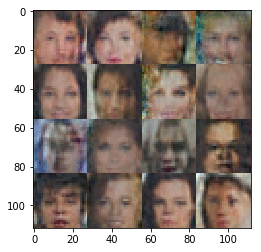

Epoch 1/2... Discriminator loss: 1.4065... Generator loss: 0.8183
Epoch 1/2... Discriminator loss: 1.3520... Generator loss: 0.8303
Epoch 1/2... Discriminator loss: 1.3837... Generator loss: 0.8210
Epoch 1/2... Discriminator loss: 1.4286... Generator loss: 0.7831
Epoch 1/2... Discriminator loss: 1.2958... Generator loss: 0.8767
Epoch 1/2... Discriminator loss: 1.3047... Generator loss: 0.8383
Epoch 1/2... Discriminator loss: 1.4318... Generator loss: 0.8261
Epoch 1/2... Discriminator loss: 1.2411... Generator loss: 0.9097
Epoch 1/2... Discriminator loss: 1.3730... Generator loss: 0.8702
Epoch 1/2... Discriminator loss: 1.3287... Generator loss: 0.8414


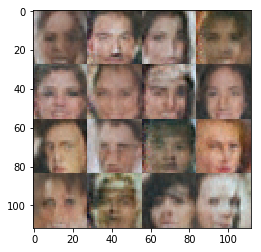

Epoch 1/2... Discriminator loss: 1.4794... Generator loss: 0.7413
Epoch 1/2... Discriminator loss: 1.4192... Generator loss: 0.8075
Epoch 1/2... Discriminator loss: 1.4219... Generator loss: 0.7857
Epoch 1/2... Discriminator loss: 1.3571... Generator loss: 0.7179
Epoch 1/2... Discriminator loss: 1.3140... Generator loss: 0.8165
Epoch 1/2... Discriminator loss: 1.3451... Generator loss: 0.7756
Epoch 1/2... Discriminator loss: 1.4043... Generator loss: 0.7569
Epoch 1/2... Discriminator loss: 1.4892... Generator loss: 0.7333
Epoch 1/2... Discriminator loss: 1.3524... Generator loss: 0.7420
Epoch 1/2... Discriminator loss: 1.3502... Generator loss: 0.7867


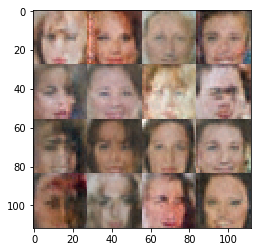

Epoch 1/2... Discriminator loss: 1.5388... Generator loss: 0.6954
Epoch 1/2... Discriminator loss: 1.2912... Generator loss: 0.7806
Epoch 1/2... Discriminator loss: 1.3723... Generator loss: 0.8043
Epoch 1/2... Discriminator loss: 1.3618... Generator loss: 0.7998
Epoch 1/2... Discriminator loss: 1.3176... Generator loss: 0.8101
Epoch 1/2... Discriminator loss: 1.3417... Generator loss: 0.7995
Epoch 1/2... Discriminator loss: 1.3152... Generator loss: 0.7932
Epoch 1/2... Discriminator loss: 1.3600... Generator loss: 0.7944
Epoch 1/2... Discriminator loss: 1.3593... Generator loss: 0.7798
Epoch 1/2... Discriminator loss: 1.3403... Generator loss: 0.7872


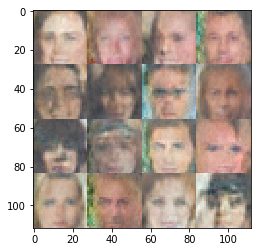

Epoch 1/2... Discriminator loss: 1.4190... Generator loss: 0.8994
Epoch 1/2... Discriminator loss: 1.3628... Generator loss: 0.8345
Epoch 1/2... Discriminator loss: 1.3926... Generator loss: 0.7601
Epoch 1/2... Discriminator loss: 1.4179... Generator loss: 0.7002
Epoch 1/2... Discriminator loss: 1.3892... Generator loss: 0.8704
Epoch 1/2... Discriminator loss: 1.3416... Generator loss: 0.8023
Epoch 1/2... Discriminator loss: 1.3589... Generator loss: 0.7318
Epoch 1/2... Discriminator loss: 1.3852... Generator loss: 0.7652
Epoch 1/2... Discriminator loss: 1.4171... Generator loss: 0.7137
Epoch 1/2... Discriminator loss: 1.5069... Generator loss: 0.7245


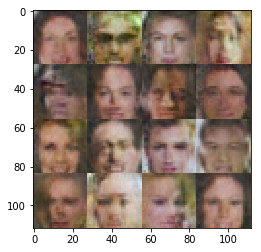

Epoch 1/2... Discriminator loss: 1.3416... Generator loss: 0.7727
Epoch 1/2... Discriminator loss: 1.4217... Generator loss: 0.7521
Epoch 1/2... Discriminator loss: 1.3978... Generator loss: 0.8382
Epoch 1/2... Discriminator loss: 1.4505... Generator loss: 0.7912
Epoch 1/2... Discriminator loss: 1.3278... Generator loss: 0.8018
Epoch 1/2... Discriminator loss: 1.3648... Generator loss: 0.7976
Epoch 1/2... Discriminator loss: 1.3139... Generator loss: 0.8728
Epoch 1/2... Discriminator loss: 1.3453... Generator loss: 0.7542
Epoch 1/2... Discriminator loss: 1.3967... Generator loss: 0.8146
Epoch 1/2... Discriminator loss: 1.4085... Generator loss: 0.7062


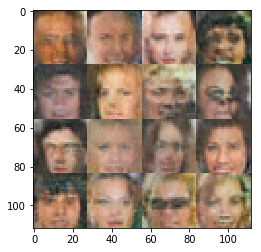

Epoch 1/2... Discriminator loss: 1.3449... Generator loss: 0.7977
Epoch 1/2... Discriminator loss: 1.3643... Generator loss: 0.7814
Epoch 1/2... Discriminator loss: 1.3929... Generator loss: 0.8243
Epoch 1/2... Discriminator loss: 1.3777... Generator loss: 0.7951
Epoch 1/2... Discriminator loss: 1.4664... Generator loss: 0.8272
Epoch 1/2... Discriminator loss: 1.3434... Generator loss: 0.8348
Epoch 1/2... Discriminator loss: 1.4610... Generator loss: 0.7929
Epoch 1/2... Discriminator loss: 1.3676... Generator loss: 0.7864
Epoch 1/2... Discriminator loss: 1.3458... Generator loss: 0.8004
Epoch 1/2... Discriminator loss: 1.3150... Generator loss: 0.8378


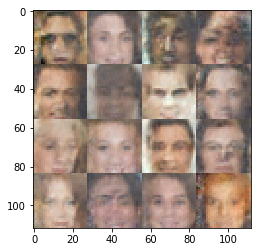

Epoch 1/2... Discriminator loss: 1.4036... Generator loss: 0.8034
Epoch 1/2... Discriminator loss: 1.3479... Generator loss: 0.7598
Epoch 1/2... Discriminator loss: 1.3272... Generator loss: 0.9124
Epoch 1/2... Discriminator loss: 1.3524... Generator loss: 0.8005
Epoch 1/2... Discriminator loss: 1.4265... Generator loss: 0.8252
Epoch 1/2... Discriminator loss: 1.3418... Generator loss: 0.7580
Epoch 1/2... Discriminator loss: 1.3394... Generator loss: 0.7830
Epoch 1/2... Discriminator loss: 1.4351... Generator loss: 0.7431
Epoch 1/2... Discriminator loss: 1.3697... Generator loss: 0.7518
Epoch 1/2... Discriminator loss: 1.3333... Generator loss: 0.8110


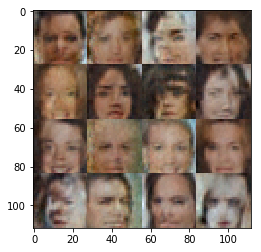

Epoch 1/2... Discriminator loss: 1.3783... Generator loss: 0.7382
Epoch 1/2... Discriminator loss: 1.3571... Generator loss: 0.8089
Epoch 1/2... Discriminator loss: 1.3940... Generator loss: 0.7217
Epoch 1/2... Discriminator loss: 1.3612... Generator loss: 0.8267
Epoch 1/2... Discriminator loss: 1.3491... Generator loss: 0.7932
Epoch 1/2... Discriminator loss: 1.4648... Generator loss: 0.7882
Epoch 1/2... Discriminator loss: 1.4005... Generator loss: 0.8754
Epoch 1/2... Discriminator loss: 1.4347... Generator loss: 0.7558
Epoch 1/2... Discriminator loss: 1.3727... Generator loss: 0.7990
Epoch 1/2... Discriminator loss: 1.4583... Generator loss: 0.8055


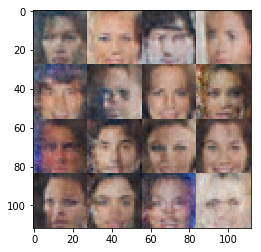

Epoch 1/2... Discriminator loss: 1.3475... Generator loss: 0.8131
Epoch 1/2... Discriminator loss: 1.3796... Generator loss: 0.7698
Epoch 1/2... Discriminator loss: 1.3480... Generator loss: 0.7835
Epoch 1/2... Discriminator loss: 1.2874... Generator loss: 0.8549
Epoch 1/2... Discriminator loss: 1.3607... Generator loss: 0.8427
Epoch 1/2... Discriminator loss: 1.3581... Generator loss: 0.7621
Epoch 1/2... Discriminator loss: 1.4012... Generator loss: 0.8019
Epoch 1/2... Discriminator loss: 1.4320... Generator loss: 0.8204
Epoch 1/2... Discriminator loss: 1.3338... Generator loss: 0.7938
Epoch 1/2... Discriminator loss: 1.3235... Generator loss: 0.8053


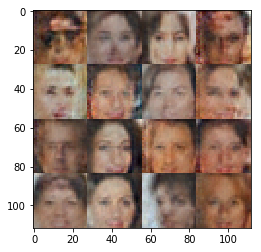

Epoch 1/2... Discriminator loss: 1.3650... Generator loss: 0.8119
Epoch 1/2... Discriminator loss: 1.2769... Generator loss: 0.8097
Epoch 1/2... Discriminator loss: 1.3980... Generator loss: 0.7955
Epoch 1/2... Discriminator loss: 1.4239... Generator loss: 0.7452
Epoch 1/2... Discriminator loss: 1.3813... Generator loss: 0.7842
Epoch 1/2... Discriminator loss: 1.4225... Generator loss: 0.8114
Epoch 1/2... Discriminator loss: 1.3977... Generator loss: 0.7927
Epoch 1/2... Discriminator loss: 1.3711... Generator loss: 0.8888
Epoch 1/2... Discriminator loss: 1.3470... Generator loss: 0.8804
Epoch 1/2... Discriminator loss: 1.2902... Generator loss: 0.9016


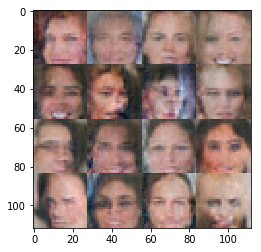

Epoch 1/2... Discriminator loss: 1.3740... Generator loss: 0.8008
Epoch 1/2... Discriminator loss: 1.3897... Generator loss: 0.8212
Epoch 1/2... Discriminator loss: 1.3533... Generator loss: 0.8364
Epoch 1/2... Discriminator loss: 1.3983... Generator loss: 0.7863
Epoch 1/2... Discriminator loss: 1.3648... Generator loss: 0.8197
Epoch 1/2... Discriminator loss: 1.4516... Generator loss: 0.6745
Epoch 1/2... Discriminator loss: 1.2613... Generator loss: 0.7978
Epoch 1/2... Discriminator loss: 1.3576... Generator loss: 0.8130
Epoch 1/2... Discriminator loss: 1.3097... Generator loss: 0.8107
Epoch 1/2... Discriminator loss: 1.3493... Generator loss: 0.8199


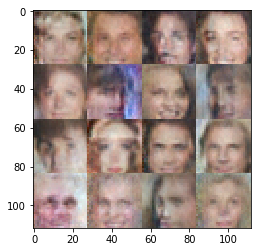

Epoch 1/2... Discriminator loss: 1.3600... Generator loss: 0.7528
Epoch 1/2... Discriminator loss: 1.3199... Generator loss: 0.8180
Epoch 1/2... Discriminator loss: 1.3560... Generator loss: 0.7349
Epoch 1/2... Discriminator loss: 1.3918... Generator loss: 0.7493
Epoch 1/2... Discriminator loss: 1.3027... Generator loss: 0.8789
Epoch 1/2... Discriminator loss: 1.3782... Generator loss: 0.8449
Epoch 1/2... Discriminator loss: 1.4237... Generator loss: 0.7210
Epoch 1/2... Discriminator loss: 1.3413... Generator loss: 0.8158
Epoch 1/2... Discriminator loss: 1.3668... Generator loss: 0.8328
Epoch 1/2... Discriminator loss: 1.4122... Generator loss: 0.7663


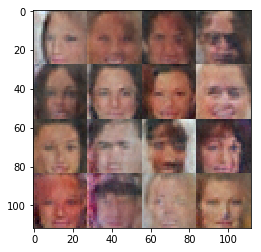

Epoch 1/2... Discriminator loss: 1.3513... Generator loss: 0.8587
Epoch 1/2... Discriminator loss: 1.3915... Generator loss: 0.6915
Epoch 1/2... Discriminator loss: 1.3644... Generator loss: 0.8997
Epoch 1/2... Discriminator loss: 1.2417... Generator loss: 0.8554
Epoch 1/2... Discriminator loss: 1.3980... Generator loss: 0.7955
Epoch 1/2... Discriminator loss: 1.4254... Generator loss: 0.7154
Epoch 1/2... Discriminator loss: 1.3948... Generator loss: 0.7729
Epoch 1/2... Discriminator loss: 1.3397... Generator loss: 0.7348
Epoch 1/2... Discriminator loss: 1.3670... Generator loss: 0.7814
Epoch 1/2... Discriminator loss: 1.4346... Generator loss: 0.8619


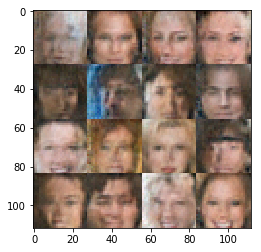

Epoch 1/2... Discriminator loss: 1.4180... Generator loss: 0.8221
Epoch 1/2... Discriminator loss: 1.3936... Generator loss: 0.8040
Epoch 1/2... Discriminator loss: 1.4111... Generator loss: 0.7977
Epoch 1/2... Discriminator loss: 1.4079... Generator loss: 0.7386
Epoch 1/2... Discriminator loss: 1.4576... Generator loss: 0.8147
Epoch 1/2... Discriminator loss: 1.3760... Generator loss: 0.8133
Epoch 1/2... Discriminator loss: 1.3925... Generator loss: 0.8072
Epoch 1/2... Discriminator loss: 1.3996... Generator loss: 0.7655
Epoch 1/2... Discriminator loss: 1.4618... Generator loss: 0.7423
Epoch 1/2... Discriminator loss: 1.3406... Generator loss: 0.7616


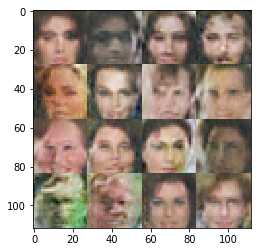

Epoch 1/2... Discriminator loss: 1.3662... Generator loss: 0.8015
Epoch 1/2... Discriminator loss: 1.3591... Generator loss: 0.8114
Epoch 1/2... Discriminator loss: 1.3487... Generator loss: 0.8881
Epoch 1/2... Discriminator loss: 1.3281... Generator loss: 0.7778
Epoch 1/2... Discriminator loss: 1.3948... Generator loss: 0.7603
Epoch 1/2... Discriminator loss: 1.4680... Generator loss: 0.6610
Epoch 1/2... Discriminator loss: 1.3507... Generator loss: 0.8023
Epoch 1/2... Discriminator loss: 1.3726... Generator loss: 0.8747
Epoch 1/2... Discriminator loss: 1.3961... Generator loss: 0.8029
Epoch 1/2... Discriminator loss: 1.4136... Generator loss: 0.7989


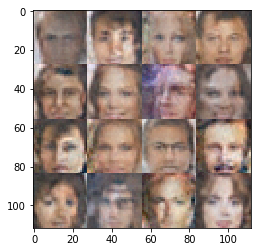

Epoch 1/2... Discriminator loss: 1.3872... Generator loss: 0.7470
Epoch 1/2... Discriminator loss: 1.4159... Generator loss: 0.7937
Epoch 1/2... Discriminator loss: 1.3860... Generator loss: 0.8238
Epoch 1/2... Discriminator loss: 1.3784... Generator loss: 0.8784
Epoch 1/2... Discriminator loss: 1.3458... Generator loss: 0.7752
Epoch 1/2... Discriminator loss: 1.3625... Generator loss: 0.8278
Epoch 1/2... Discriminator loss: 1.4371... Generator loss: 0.7276
Epoch 1/2... Discriminator loss: 1.4011... Generator loss: 0.7431
Epoch 1/2... Discriminator loss: 1.4138... Generator loss: 0.7515
Epoch 1/2... Discriminator loss: 1.4436... Generator loss: 0.7023


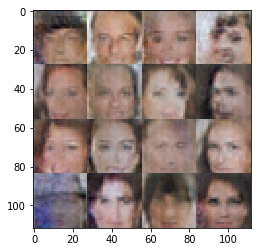

Epoch 1/2... Discriminator loss: 1.4113... Generator loss: 0.7432
Epoch 1/2... Discriminator loss: 1.3598... Generator loss: 0.8681
Epoch 1/2... Discriminator loss: 1.3935... Generator loss: 0.7613
Epoch 1/2... Discriminator loss: 1.4069... Generator loss: 0.8501
Epoch 1/2... Discriminator loss: 1.4040... Generator loss: 0.8357
Epoch 1/2... Discriminator loss: 1.3768... Generator loss: 0.7400
Epoch 1/2... Discriminator loss: 1.3595... Generator loss: 0.8426
Epoch 1/2... Discriminator loss: 1.4338... Generator loss: 0.7797
Epoch 1/2... Discriminator loss: 1.3111... Generator loss: 0.8053
Epoch 1/2... Discriminator loss: 1.3793... Generator loss: 0.7797


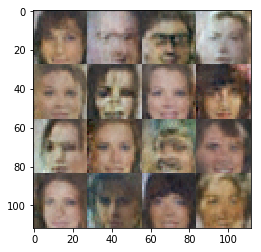

Epoch 1/2... Discriminator loss: 1.3574... Generator loss: 0.8259
Epoch 1/2... Discriminator loss: 1.3627... Generator loss: 0.8297
Epoch 1/2... Discriminator loss: 1.3600... Generator loss: 0.7687
Epoch 1/2... Discriminator loss: 1.3884... Generator loss: 0.7796
Epoch 1/2... Discriminator loss: 1.3703... Generator loss: 0.8466
Epoch 1/2... Discriminator loss: 1.4069... Generator loss: 0.8028
Epoch 1/2... Discriminator loss: 1.3671... Generator loss: 0.7344
Epoch 1/2... Discriminator loss: 1.5121... Generator loss: 0.7155
Epoch 1/2... Discriminator loss: 1.3194... Generator loss: 0.8061
Epoch 1/2... Discriminator loss: 1.3880... Generator loss: 0.7912


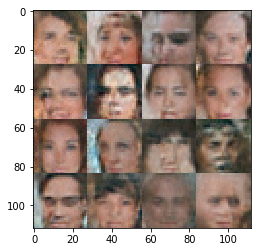

Epoch 1/2... Discriminator loss: 1.4046... Generator loss: 0.8476
Epoch 1/2... Discriminator loss: 1.3531... Generator loss: 0.8338
Epoch 1/2... Discriminator loss: 1.4068... Generator loss: 0.8117
Epoch 1/2... Discriminator loss: 1.3991... Generator loss: 0.8071
Epoch 1/2... Discriminator loss: 1.3427... Generator loss: 0.8246
Epoch 1/2... Discriminator loss: 1.3828... Generator loss: 0.7615
Epoch 1/2... Discriminator loss: 1.4189... Generator loss: 0.7524
Epoch 1/2... Discriminator loss: 1.4220... Generator loss: 0.7277
Epoch 1/2... Discriminator loss: 1.3879... Generator loss: 0.7801
Epoch 1/2... Discriminator loss: 1.3374... Generator loss: 0.7938


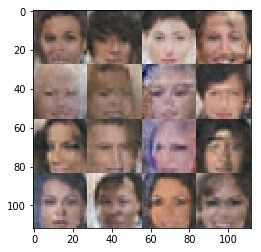

Epoch 1/2... Discriminator loss: 1.2997... Generator loss: 0.8567
Epoch 1/2... Discriminator loss: 1.3724... Generator loss: 0.8215
Epoch 1/2... Discriminator loss: 1.3902... Generator loss: 0.8081
Epoch 1/2... Discriminator loss: 1.4127... Generator loss: 0.7951
Epoch 1/2... Discriminator loss: 1.3574... Generator loss: 0.8052
Epoch 1/2... Discriminator loss: 1.3767... Generator loss: 0.8119
Epoch 1/2... Discriminator loss: 1.3378... Generator loss: 0.8223
Epoch 1/2... Discriminator loss: 1.3641... Generator loss: 0.7698
Epoch 1/2... Discriminator loss: 1.2558... Generator loss: 0.8675
Epoch 1/2... Discriminator loss: 1.3822... Generator loss: 0.8365


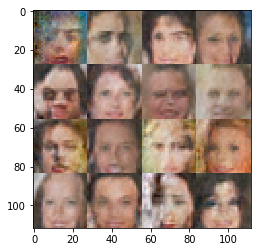

Epoch 1/2... Discriminator loss: 1.3665... Generator loss: 0.7397
Epoch 1/2... Discriminator loss: 1.3600... Generator loss: 0.7620
Epoch 1/2... Discriminator loss: 1.3897... Generator loss: 0.7465
Epoch 1/2... Discriminator loss: 1.3599... Generator loss: 0.7589
Epoch 1/2... Discriminator loss: 1.3849... Generator loss: 0.8361
Epoch 1/2... Discriminator loss: 1.4033... Generator loss: 0.7619
Epoch 1/2... Discriminator loss: 1.3678... Generator loss: 0.7940
Epoch 1/2... Discriminator loss: 1.3090... Generator loss: 0.8660
Epoch 1/2... Discriminator loss: 1.3816... Generator loss: 0.8019
Epoch 1/2... Discriminator loss: 1.4049... Generator loss: 0.8058


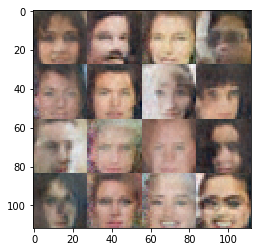

Epoch 1/2... Discriminator loss: 1.3810... Generator loss: 0.7300
Epoch 1/2... Discriminator loss: 1.3993... Generator loss: 0.7360
Epoch 1/2... Discriminator loss: 1.3387... Generator loss: 0.7800
Epoch 1/2... Discriminator loss: 1.3481... Generator loss: 0.8451
Epoch 1/2... Discriminator loss: 1.3676... Generator loss: 0.7992
Epoch 1/2... Discriminator loss: 1.4043... Generator loss: 0.7519
Epoch 1/2... Discriminator loss: 1.3442... Generator loss: 0.7855
Epoch 1/2... Discriminator loss: 1.3272... Generator loss: 0.8484
Epoch 1/2... Discriminator loss: 1.4251... Generator loss: 0.8219
Epoch 1/2... Discriminator loss: 1.3738... Generator loss: 0.7817


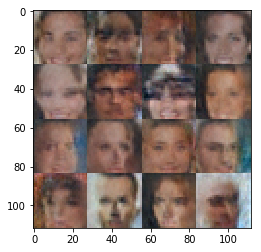

Epoch 1/2... Discriminator loss: 1.3777... Generator loss: 0.8248
Epoch 1/2... Discriminator loss: 1.4319... Generator loss: 0.7992
Epoch 1/2... Discriminator loss: 1.3474... Generator loss: 0.7802
Epoch 1/2... Discriminator loss: 1.3541... Generator loss: 0.7412
Epoch 1/2... Discriminator loss: 1.2931... Generator loss: 0.8068
Epoch 1/2... Discriminator loss: 1.4153... Generator loss: 0.8214
Epoch 1/2... Discriminator loss: 1.3079... Generator loss: 0.7667
Epoch 1/2... Discriminator loss: 1.4078... Generator loss: 0.8139
Epoch 1/2... Discriminator loss: 1.3793... Generator loss: 0.7998
Epoch 1/2... Discriminator loss: 1.3853... Generator loss: 0.8053


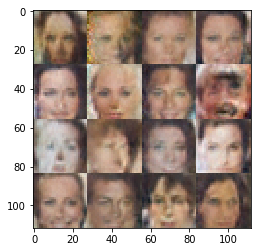

Epoch 1/2... Discriminator loss: 1.3190... Generator loss: 0.8212
Epoch 1/2... Discriminator loss: 1.3617... Generator loss: 0.7634
Epoch 1/2... Discriminator loss: 1.3807... Generator loss: 0.7710
Epoch 1/2... Discriminator loss: 1.3353... Generator loss: 0.7942
Epoch 1/2... Discriminator loss: 1.3910... Generator loss: 0.8422
Epoch 1/2... Discriminator loss: 1.3337... Generator loss: 0.7530
Epoch 1/2... Discriminator loss: 1.3808... Generator loss: 0.7901
Epoch 1/2... Discriminator loss: 1.3372... Generator loss: 0.7513
Epoch 1/2... Discriminator loss: 1.4112... Generator loss: 0.7152
Epoch 1/2... Discriminator loss: 1.2831... Generator loss: 0.8026


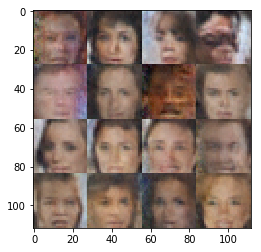

Epoch 1/2... Discriminator loss: 1.3459... Generator loss: 0.8447
Epoch 1/2... Discriminator loss: 1.4004... Generator loss: 0.7305
Epoch 1/2... Discriminator loss: 1.3961... Generator loss: 0.7385
Epoch 1/2... Discriminator loss: 1.3911... Generator loss: 0.8176
Epoch 1/2... Discriminator loss: 1.3994... Generator loss: 0.8051
Epoch 1/2... Discriminator loss: 1.3242... Generator loss: 0.8281
Epoch 1/2... Discriminator loss: 1.3851... Generator loss: 0.8372
Epoch 1/2... Discriminator loss: 1.2951... Generator loss: 0.8312
Epoch 1/2... Discriminator loss: 1.3993... Generator loss: 0.8625
Epoch 1/2... Discriminator loss: 1.4236... Generator loss: 0.7442


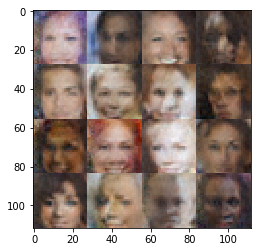

Epoch 1/2... Discriminator loss: 1.3524... Generator loss: 0.8181
Epoch 1/2... Discriminator loss: 1.3277... Generator loss: 0.8515
Epoch 1/2... Discriminator loss: 1.3782... Generator loss: 0.7472
Epoch 1/2... Discriminator loss: 1.3868... Generator loss: 0.7480
Epoch 1/2... Discriminator loss: 1.3287... Generator loss: 0.7407
Epoch 1/2... Discriminator loss: 1.3846... Generator loss: 0.7806
Epoch 1/2... Discriminator loss: 1.3528... Generator loss: 0.8084
Epoch 1/2... Discriminator loss: 1.3390... Generator loss: 0.8635
Epoch 1/2... Discriminator loss: 1.3297... Generator loss: 0.7710
Epoch 1/2... Discriminator loss: 1.4097... Generator loss: 0.7837


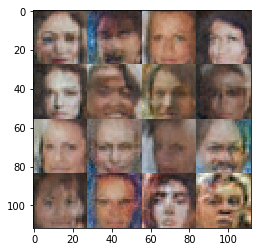

Epoch 1/2... Discriminator loss: 1.3528... Generator loss: 0.7982
Epoch 1/2... Discriminator loss: 1.3221... Generator loss: 0.8694
Epoch 1/2... Discriminator loss: 1.3696... Generator loss: 0.7363
Epoch 1/2... Discriminator loss: 1.3703... Generator loss: 0.7721
Epoch 1/2... Discriminator loss: 1.4410... Generator loss: 0.7537
Epoch 1/2... Discriminator loss: 1.3933... Generator loss: 0.8235
Epoch 1/2... Discriminator loss: 1.3253... Generator loss: 0.8375
Epoch 1/2... Discriminator loss: 1.4204... Generator loss: 0.7782
Epoch 1/2... Discriminator loss: 1.3721... Generator loss: 0.7599
Epoch 1/2... Discriminator loss: 1.4341... Generator loss: 0.6942


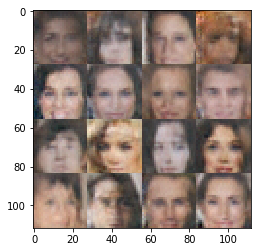

Epoch 1/2... Discriminator loss: 1.3664... Generator loss: 0.7705
Epoch 1/2... Discriminator loss: 1.3749... Generator loss: 0.7500
Epoch 1/2... Discriminator loss: 1.3365... Generator loss: 0.7752
Epoch 1/2... Discriminator loss: 1.3715... Generator loss: 0.7324
Epoch 1/2... Discriminator loss: 1.4056... Generator loss: 0.7994
Epoch 1/2... Discriminator loss: 1.3819... Generator loss: 0.8605
Epoch 1/2... Discriminator loss: 1.3471... Generator loss: 0.7952
Epoch 1/2... Discriminator loss: 1.3419... Generator loss: 0.8031
Epoch 1/2... Discriminator loss: 1.3461... Generator loss: 0.8044
Epoch 1/2... Discriminator loss: 1.3967... Generator loss: 0.7511


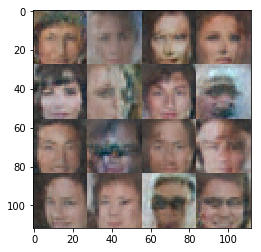

Epoch 1/2... Discriminator loss: 1.3339... Generator loss: 0.8170
Epoch 1/2... Discriminator loss: 1.4065... Generator loss: 0.8472
Epoch 1/2... Discriminator loss: 1.3945... Generator loss: 0.7005
Epoch 1/2... Discriminator loss: 1.3630... Generator loss: 0.7330
Epoch 1/2... Discriminator loss: 1.3202... Generator loss: 0.8556
Epoch 1/2... Discriminator loss: 1.3529... Generator loss: 0.7767
Epoch 1/2... Discriminator loss: 1.4394... Generator loss: 0.7846
Epoch 1/2... Discriminator loss: 1.3681... Generator loss: 0.8269
Epoch 1/2... Discriminator loss: 1.3747... Generator loss: 0.8427
Epoch 1/2... Discriminator loss: 1.3736... Generator loss: 0.7377


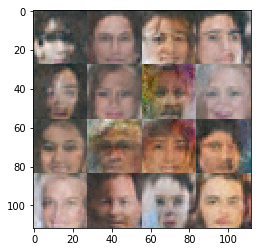

Epoch 1/2... Discriminator loss: 1.3433... Generator loss: 0.7467
Epoch 1/2... Discriminator loss: 1.3970... Generator loss: 0.8096
Epoch 1/2... Discriminator loss: 1.3900... Generator loss: 0.7828
Epoch 1/2... Discriminator loss: 1.4161... Generator loss: 0.7616
Epoch 1/2... Discriminator loss: 1.2826... Generator loss: 0.8689
Epoch 1/2... Discriminator loss: 1.4119... Generator loss: 0.7601
Epoch 1/2... Discriminator loss: 1.3962... Generator loss: 0.7656
Epoch 1/2... Discriminator loss: 1.3998... Generator loss: 0.7952
Epoch 1/2... Discriminator loss: 1.3595... Generator loss: 0.8481
Epoch 1/2... Discriminator loss: 1.3612... Generator loss: 0.7957


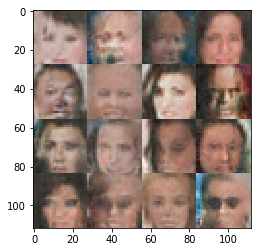

Epoch 1/2... Discriminator loss: 1.3838... Generator loss: 0.7742
Epoch 1/2... Discriminator loss: 1.4319... Generator loss: 0.6707
Epoch 1/2... Discriminator loss: 1.3517... Generator loss: 0.8982
Epoch 1/2... Discriminator loss: 1.3998... Generator loss: 0.7810
Epoch 1/2... Discriminator loss: 1.3340... Generator loss: 0.8528
Epoch 1/2... Discriminator loss: 1.3739... Generator loss: 0.8546
Epoch 1/2... Discriminator loss: 1.3342... Generator loss: 0.8336
Epoch 1/2... Discriminator loss: 1.3432... Generator loss: 0.7610
Epoch 1/2... Discriminator loss: 1.2905... Generator loss: 0.7985
Epoch 1/2... Discriminator loss: 1.3699... Generator loss: 0.8505


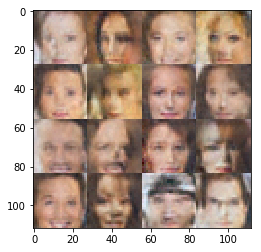

Epoch 1/2... Discriminator loss: 1.3573... Generator loss: 0.8025
Epoch 1/2... Discriminator loss: 1.3513... Generator loss: 0.7970
Epoch 1/2... Discriminator loss: 1.4260... Generator loss: 0.7378
Epoch 1/2... Discriminator loss: 1.4106... Generator loss: 0.8478
Epoch 1/2... Discriminator loss: 1.3489... Generator loss: 0.7385
Epoch 1/2... Discriminator loss: 1.3563... Generator loss: 0.7097
Epoch 1/2... Discriminator loss: 1.3631... Generator loss: 0.8178
Epoch 1/2... Discriminator loss: 1.3257... Generator loss: 0.8194
Epoch 1/2... Discriminator loss: 1.3565... Generator loss: 0.8592
Epoch 1/2... Discriminator loss: 1.3539... Generator loss: 0.8555


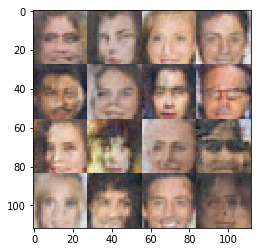

Epoch 1/2... Discriminator loss: 1.3926... Generator loss: 0.8070
Epoch 1/2... Discriminator loss: 1.4125... Generator loss: 0.8037
Epoch 1/2... Discriminator loss: 1.3415... Generator loss: 0.7617
Epoch 1/2... Discriminator loss: 1.3236... Generator loss: 0.8070
Epoch 1/2... Discriminator loss: 1.3419... Generator loss: 0.7741
Epoch 1/2... Discriminator loss: 1.3788... Generator loss: 0.8416
Epoch 1/2... Discriminator loss: 1.4732... Generator loss: 0.7449
Epoch 1/2... Discriminator loss: 1.3611... Generator loss: 0.7563
Epoch 1/2... Discriminator loss: 1.4035... Generator loss: 0.7635
Epoch 1/2... Discriminator loss: 1.3704... Generator loss: 0.8524


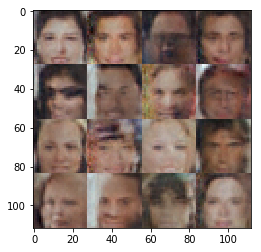

Epoch 1/2... Discriminator loss: 1.3886... Generator loss: 0.7911
Epoch 1/2... Discriminator loss: 1.3670... Generator loss: 0.8398
Epoch 1/2... Discriminator loss: 1.3798... Generator loss: 0.7820
Epoch 1/2... Discriminator loss: 1.3991... Generator loss: 0.7782
Epoch 1/2... Discriminator loss: 1.4006... Generator loss: 0.8071
Epoch 1/2... Discriminator loss: 1.4009... Generator loss: 0.7677
Epoch 1/2... Discriminator loss: 1.3926... Generator loss: 0.8633
Epoch 1/2... Discriminator loss: 1.3532... Generator loss: 0.7851
Epoch 1/2... Discriminator loss: 1.3855... Generator loss: 0.7769
Epoch 1/2... Discriminator loss: 1.3480... Generator loss: 0.8936


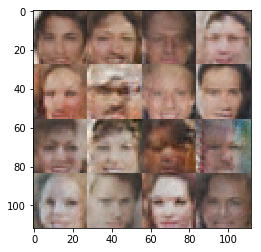

Epoch 1/2... Discriminator loss: 1.3945... Generator loss: 0.7801
Epoch 1/2... Discriminator loss: 1.3969... Generator loss: 0.8539
Epoch 1/2... Discriminator loss: 1.3529... Generator loss: 0.8073
Epoch 1/2... Discriminator loss: 1.3637... Generator loss: 0.8745
Epoch 1/2... Discriminator loss: 1.3636... Generator loss: 0.8099
Epoch 1/2... Discriminator loss: 1.3769... Generator loss: 0.8252
Epoch 1/2... Discriminator loss: 1.3384... Generator loss: 0.8130
Epoch 1/2... Discriminator loss: 1.3627... Generator loss: 0.8092
Epoch 1/2... Discriminator loss: 1.3659... Generator loss: 0.7293
Epoch 1/2... Discriminator loss: 1.3730... Generator loss: 0.8440


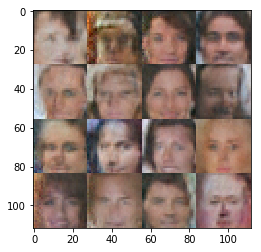

Epoch 1/2... Discriminator loss: 1.3416... Generator loss: 0.8005
Epoch 1/2... Discriminator loss: 1.3162... Generator loss: 0.7946
Epoch 1/2... Discriminator loss: 1.3004... Generator loss: 0.8054
Epoch 1/2... Discriminator loss: 1.3918... Generator loss: 0.8277
Epoch 1/2... Discriminator loss: 1.3907... Generator loss: 0.7322
Epoch 1/2... Discriminator loss: 1.3649... Generator loss: 0.7594
Epoch 1/2... Discriminator loss: 1.3844... Generator loss: 0.8648
Epoch 1/2... Discriminator loss: 1.3749... Generator loss: 0.8050
Epoch 1/2... Discriminator loss: 1.3579... Generator loss: 0.8491
Epoch 1/2... Discriminator loss: 1.4390... Generator loss: 0.8156


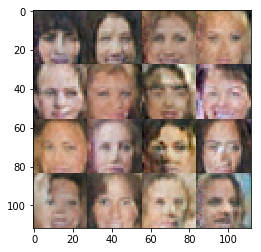

Epoch 1/2... Discriminator loss: 1.3982... Generator loss: 0.8154
Epoch 1/2... Discriminator loss: 1.3686... Generator loss: 0.7519
Epoch 1/2... Discriminator loss: 1.3827... Generator loss: 0.8395
Epoch 1/2... Discriminator loss: 1.3731... Generator loss: 0.7998
Epoch 1/2... Discriminator loss: 1.3920... Generator loss: 0.8248
Epoch 1/2... Discriminator loss: 1.3907... Generator loss: 0.7580
Epoch 1/2... Discriminator loss: 1.3968... Generator loss: 0.7798
Epoch 1/2... Discriminator loss: 1.3265... Generator loss: 0.7799
Epoch 1/2... Discriminator loss: 1.3991... Generator loss: 0.7795
Epoch 1/2... Discriminator loss: 1.4095... Generator loss: 0.7498


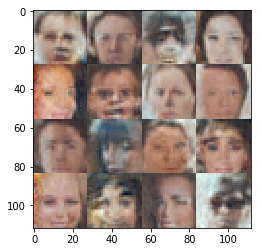

Epoch 1/2... Discriminator loss: 1.3647... Generator loss: 0.7851
Epoch 1/2... Discriminator loss: 1.4311... Generator loss: 0.8128
Epoch 1/2... Discriminator loss: 1.3760... Generator loss: 0.8177
Epoch 1/2... Discriminator loss: 1.4016... Generator loss: 0.8501
Epoch 1/2... Discriminator loss: 1.4497... Generator loss: 0.7574
Epoch 1/2... Discriminator loss: 1.3658... Generator loss: 0.8579
Epoch 1/2... Discriminator loss: 1.3986... Generator loss: 0.8555
Epoch 1/2... Discriminator loss: 1.4005... Generator loss: 0.7985
Epoch 1/2... Discriminator loss: 1.4130... Generator loss: 0.8007
Epoch 1/2... Discriminator loss: 1.4093... Generator loss: 0.7797


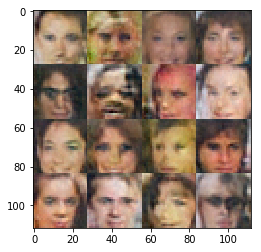

Epoch 1/2... Discriminator loss: 1.3637... Generator loss: 0.7984
Epoch 1/2... Discriminator loss: 1.4109... Generator loss: 0.7825
Epoch 1/2... Discriminator loss: 1.3266... Generator loss: 0.8258
Epoch 1/2... Discriminator loss: 1.3471... Generator loss: 0.8115
Epoch 1/2... Discriminator loss: 1.3820... Generator loss: 0.8492
Epoch 1/2... Discriminator loss: 1.3280... Generator loss: 0.7660
Epoch 1/2... Discriminator loss: 1.3848... Generator loss: 0.7690
Epoch 1/2... Discriminator loss: 1.3483... Generator loss: 0.8032
Epoch 1/2... Discriminator loss: 1.3814... Generator loss: 0.8302
Epoch 1/2... Discriminator loss: 1.3759... Generator loss: 0.8396


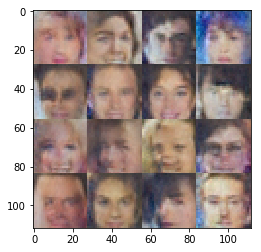

Epoch 1/2... Discriminator loss: 1.4431... Generator loss: 0.7404
Epoch 1/2... Discriminator loss: 1.3406... Generator loss: 0.8659
Epoch 1/2... Discriminator loss: 1.4138... Generator loss: 0.8266
Epoch 1/2... Discriminator loss: 1.3941... Generator loss: 0.7675
Epoch 1/2... Discriminator loss: 1.3566... Generator loss: 0.7913
Epoch 1/2... Discriminator loss: 1.3191... Generator loss: 0.7852
Epoch 1/2... Discriminator loss: 1.3347... Generator loss: 0.8372
Epoch 1/2... Discriminator loss: 1.3373... Generator loss: 0.8455
Epoch 1/2... Discriminator loss: 1.3691... Generator loss: 0.7786
Epoch 1/2... Discriminator loss: 1.3273... Generator loss: 0.8383


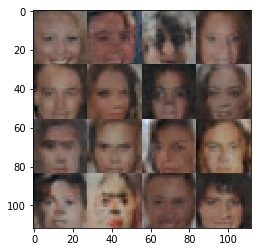

Epoch 1/2... Discriminator loss: 1.3461... Generator loss: 0.8111
Epoch 1/2... Discriminator loss: 1.3976... Generator loss: 0.8188
Epoch 1/2... Discriminator loss: 1.2927... Generator loss: 0.8376
Epoch 1/2... Discriminator loss: 1.3878... Generator loss: 0.7782
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 0.8140
Epoch 1/2... Discriminator loss: 1.3018... Generator loss: 0.8805
Epoch 1/2... Discriminator loss: 1.3760... Generator loss: 0.7971
Epoch 1/2... Discriminator loss: 1.4023... Generator loss: 0.8007
Epoch 1/2... Discriminator loss: 1.3887... Generator loss: 0.8447
Epoch 1/2... Discriminator loss: 1.3908... Generator loss: 0.8226


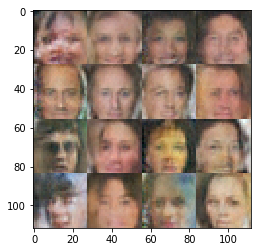

Epoch 1/2... Discriminator loss: 1.3337... Generator loss: 0.8407
Epoch 1/2... Discriminator loss: 1.4130... Generator loss: 0.7961
Epoch 1/2... Discriminator loss: 1.3869... Generator loss: 0.8357
Epoch 1/2... Discriminator loss: 1.3632... Generator loss: 0.8106
Epoch 1/2... Discriminator loss: 1.3888... Generator loss: 0.7670
Epoch 1/2... Discriminator loss: 1.3808... Generator loss: 0.8298
Epoch 1/2... Discriminator loss: 1.3591... Generator loss: 0.8285
Epoch 1/2... Discriminator loss: 1.3074... Generator loss: 0.7520
Epoch 1/2... Discriminator loss: 1.3358... Generator loss: 0.8216
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 0.7832


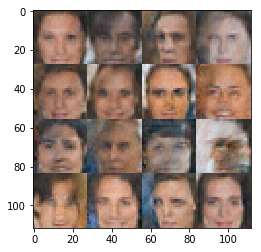

Epoch 1/2... Discriminator loss: 1.3015... Generator loss: 0.8096
Epoch 1/2... Discriminator loss: 1.3733... Generator loss: 0.8297
Epoch 1/2... Discriminator loss: 1.3941... Generator loss: 0.7486
Epoch 1/2... Discriminator loss: 1.3845... Generator loss: 0.7436
Epoch 1/2... Discriminator loss: 1.3651... Generator loss: 0.7379
Epoch 1/2... Discriminator loss: 1.3333... Generator loss: 0.8235
Epoch 1/2... Discriminator loss: 1.3250... Generator loss: 0.7853
Epoch 1/2... Discriminator loss: 1.3610... Generator loss: 0.7763
Epoch 1/2... Discriminator loss: 1.3659... Generator loss: 0.7665
Epoch 1/2... Discriminator loss: 1.3402... Generator loss: 0.7462


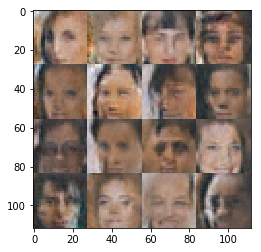

Epoch 1/2... Discriminator loss: 1.3214... Generator loss: 0.8163
Epoch 1/2... Discriminator loss: 1.4251... Generator loss: 0.7892
Epoch 1/2... Discriminator loss: 1.4748... Generator loss: 0.7273
Epoch 1/2... Discriminator loss: 1.3564... Generator loss: 0.7939
Epoch 1/2... Discriminator loss: 1.3404... Generator loss: 0.8324
Epoch 1/2... Discriminator loss: 1.3047... Generator loss: 0.8849
Epoch 1/2... Discriminator loss: 1.3384... Generator loss: 0.8332
Epoch 1/2... Discriminator loss: 1.4298... Generator loss: 0.7701
Epoch 1/2... Discriminator loss: 1.3824... Generator loss: 0.8742
Epoch 1/2... Discriminator loss: 1.3512... Generator loss: 0.7639


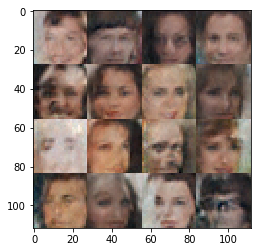

Epoch 1/2... Discriminator loss: 1.3443... Generator loss: 0.7967
Epoch 1/2... Discriminator loss: 1.3390... Generator loss: 0.7643
Epoch 1/2... Discriminator loss: 1.3582... Generator loss: 0.8167
Epoch 1/2... Discriminator loss: 1.3787... Generator loss: 0.7616
Epoch 1/2... Discriminator loss: 1.3932... Generator loss: 0.8610
Epoch 1/2... Discriminator loss: 1.3602... Generator loss: 0.7430
Epoch 1/2... Discriminator loss: 1.3556... Generator loss: 0.8122
Epoch 1/2... Discriminator loss: 1.3679... Generator loss: 0.7986
Epoch 1/2... Discriminator loss: 1.3790... Generator loss: 0.7335
Epoch 1/2... Discriminator loss: 1.4071... Generator loss: 0.7483


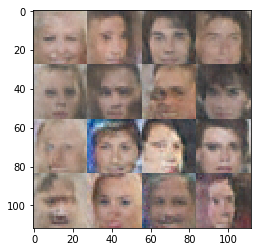

Epoch 1/2... Discriminator loss: 1.3594... Generator loss: 0.7222
Epoch 1/2... Discriminator loss: 1.4260... Generator loss: 0.7713
Epoch 1/2... Discriminator loss: 1.4278... Generator loss: 0.7772
Epoch 1/2... Discriminator loss: 1.2972... Generator loss: 0.8720
Epoch 1/2... Discriminator loss: 1.3378... Generator loss: 0.8101
Epoch 1/2... Discriminator loss: 1.2983... Generator loss: 0.8645
Epoch 1/2... Discriminator loss: 1.4336... Generator loss: 0.7570
Epoch 1/2... Discriminator loss: 1.3729... Generator loss: 0.7785
Epoch 1/2... Discriminator loss: 1.3514... Generator loss: 0.8301
Epoch 1/2... Discriminator loss: 1.3656... Generator loss: 0.8499


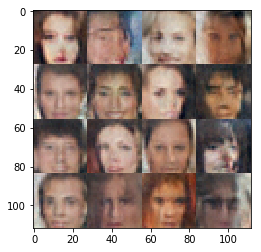

Epoch 1/2... Discriminator loss: 1.3188... Generator loss: 0.8802
Epoch 1/2... Discriminator loss: 1.4047... Generator loss: 0.8501
Epoch 1/2... Discriminator loss: 1.3619... Generator loss: 0.8245
Epoch 1/2... Discriminator loss: 1.4028... Generator loss: 0.8001
Epoch 1/2... Discriminator loss: 1.3879... Generator loss: 0.7702
Epoch 1/2... Discriminator loss: 1.3674... Generator loss: 0.7332
Epoch 1/2... Discriminator loss: 1.4408... Generator loss: 0.7306
Epoch 1/2... Discriminator loss: 1.3950... Generator loss: 0.8087
Epoch 1/2... Discriminator loss: 1.3676... Generator loss: 0.7723
Epoch 1/2... Discriminator loss: 1.3386... Generator loss: 0.8911


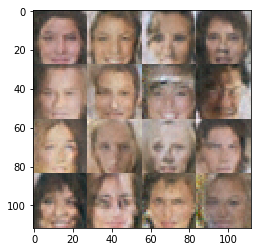

Epoch 1/2... Discriminator loss: 1.3899... Generator loss: 0.7291
Epoch 1/2... Discriminator loss: 1.3543... Generator loss: 0.8598
Epoch 1/2... Discriminator loss: 1.3433... Generator loss: 0.8109
Epoch 1/2... Discriminator loss: 1.3648... Generator loss: 0.8097
Epoch 1/2... Discriminator loss: 1.3804... Generator loss: 0.7911
Epoch 1/2... Discriminator loss: 1.3868... Generator loss: 0.8660
Epoch 1/2... Discriminator loss: 1.2979... Generator loss: 0.8576
Epoch 1/2... Discriminator loss: 1.3547... Generator loss: 0.7664
Epoch 1/2... Discriminator loss: 1.3792... Generator loss: 0.7535
Epoch 1/2... Discriminator loss: 1.4152... Generator loss: 0.8119


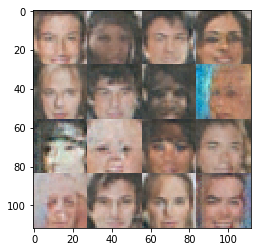

Epoch 1/2... Discriminator loss: 1.3596... Generator loss: 0.8065
Epoch 1/2... Discriminator loss: 1.3590... Generator loss: 0.9159
Epoch 1/2... Discriminator loss: 1.2734... Generator loss: 0.8624
Epoch 1/2... Discriminator loss: 1.3593... Generator loss: 0.7838
Epoch 1/2... Discriminator loss: 1.3736... Generator loss: 0.8664
Epoch 1/2... Discriminator loss: 1.3671... Generator loss: 0.7725
Epoch 1/2... Discriminator loss: 1.2961... Generator loss: 0.8389
Epoch 1/2... Discriminator loss: 1.3585... Generator loss: 0.7551
Epoch 1/2... Discriminator loss: 1.3324... Generator loss: 0.8310
Epoch 1/2... Discriminator loss: 1.3753... Generator loss: 0.8247


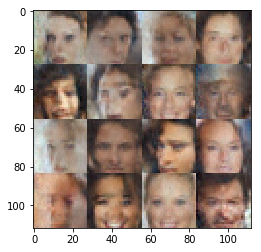

Epoch 1/2... Discriminator loss: 1.3081... Generator loss: 0.8417
Epoch 1/2... Discriminator loss: 1.3477... Generator loss: 0.7581
Epoch 1/2... Discriminator loss: 1.3673... Generator loss: 0.8359
Epoch 1/2... Discriminator loss: 1.3547... Generator loss: 0.7792
Epoch 1/2... Discriminator loss: 1.3787... Generator loss: 0.7879
Epoch 1/2... Discriminator loss: 1.3592... Generator loss: 0.8194
Epoch 1/2... Discriminator loss: 1.3559... Generator loss: 0.8112
Epoch 1/2... Discriminator loss: 1.3234... Generator loss: 0.7516
Epoch 1/2... Discriminator loss: 1.3858... Generator loss: 0.8193
Epoch 1/2... Discriminator loss: 1.3738... Generator loss: 0.7617


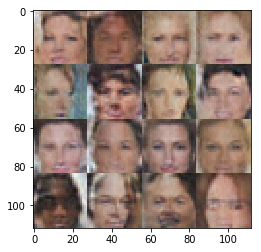

Epoch 1/2... Discriminator loss: 1.4028... Generator loss: 0.7614
Epoch 1/2... Discriminator loss: 1.3521... Generator loss: 0.8286
Epoch 1/2... Discriminator loss: 1.3981... Generator loss: 0.8602
Epoch 1/2... Discriminator loss: 1.3511... Generator loss: 0.7747
Epoch 1/2... Discriminator loss: 1.3557... Generator loss: 0.8786
Epoch 1/2... Discriminator loss: 1.3385... Generator loss: 0.8111
Epoch 1/2... Discriminator loss: 1.3763... Generator loss: 0.7997
Epoch 1/2... Discriminator loss: 1.3319... Generator loss: 0.8074
Epoch 1/2... Discriminator loss: 1.3712... Generator loss: 0.7995
Epoch 1/2... Discriminator loss: 1.3045... Generator loss: 0.8380


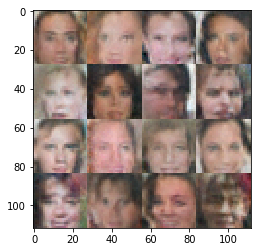

Epoch 1/2... Discriminator loss: 1.3832... Generator loss: 0.7516
Epoch 1/2... Discriminator loss: 1.3458... Generator loss: 0.7367
Epoch 1/2... Discriminator loss: 1.3780... Generator loss: 0.7512
Epoch 1/2... Discriminator loss: 1.3394... Generator loss: 0.8154
Epoch 1/2... Discriminator loss: 1.4021... Generator loss: 0.7357
Epoch 1/2... Discriminator loss: 1.3042... Generator loss: 0.8294
Epoch 1/2... Discriminator loss: 1.3983... Generator loss: 0.7516
Epoch 1/2... Discriminator loss: 1.3461... Generator loss: 0.7952
Epoch 1/2... Discriminator loss: 1.4379... Generator loss: 0.7810
Epoch 1/2... Discriminator loss: 1.3876... Generator loss: 0.7543


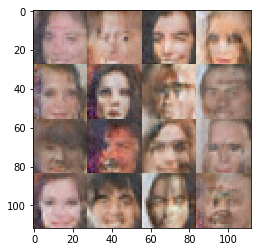

Epoch 1/2... Discriminator loss: 1.3070... Generator loss: 0.8559
Epoch 1/2... Discriminator loss: 1.3406... Generator loss: 0.7574
Epoch 1/2... Discriminator loss: 1.4201... Generator loss: 0.7714
Epoch 1/2... Discriminator loss: 1.3456... Generator loss: 0.8831
Epoch 1/2... Discriminator loss: 1.3566... Generator loss: 0.8394
Epoch 1/2... Discriminator loss: 1.3502... Generator loss: 0.8399
Epoch 1/2... Discriminator loss: 1.4173... Generator loss: 0.7855
Epoch 1/2... Discriminator loss: 1.4010... Generator loss: 0.7948
Epoch 1/2... Discriminator loss: 1.3433... Generator loss: 0.8062
Epoch 1/2... Discriminator loss: 1.3849... Generator loss: 0.7594


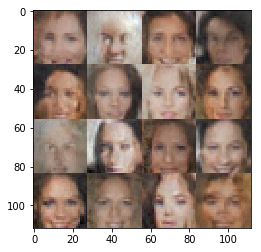

Epoch 1/2... Discriminator loss: 1.3432... Generator loss: 0.8260
Epoch 1/2... Discriminator loss: 1.3333... Generator loss: 0.7552
Epoch 1/2... Discriminator loss: 1.3596... Generator loss: 0.7889
Epoch 1/2... Discriminator loss: 1.3522... Generator loss: 0.8193
Epoch 1/2... Discriminator loss: 1.3792... Generator loss: 0.8026
Epoch 1/2... Discriminator loss: 1.3921... Generator loss: 0.8001
Epoch 1/2... Discriminator loss: 1.3471... Generator loss: 0.8184
Epoch 1/2... Discriminator loss: 1.4347... Generator loss: 0.7141
Epoch 1/2... Discriminator loss: 1.3378... Generator loss: 0.7667
Epoch 1/2... Discriminator loss: 1.3964... Generator loss: 0.8083


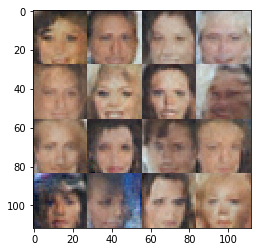

Epoch 1/2... Discriminator loss: 1.3824... Generator loss: 0.7862
Epoch 1/2... Discriminator loss: 1.3415... Generator loss: 0.7849
Epoch 1/2... Discriminator loss: 1.3325... Generator loss: 0.7920
Epoch 1/2... Discriminator loss: 1.3386... Generator loss: 0.7517
Epoch 1/2... Discriminator loss: 1.3811... Generator loss: 0.8677
Epoch 1/2... Discriminator loss: 1.4299... Generator loss: 0.8126
Epoch 1/2... Discriminator loss: 1.3907... Generator loss: 0.8237
Epoch 1/2... Discriminator loss: 1.3178... Generator loss: 0.8616
Epoch 1/2... Discriminator loss: 1.3736... Generator loss: 0.7832
Epoch 1/2... Discriminator loss: 1.3817... Generator loss: 0.8715


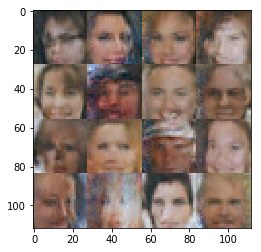

Epoch 1/2... Discriminator loss: 1.4276... Generator loss: 0.7474
Epoch 1/2... Discriminator loss: 1.3452... Generator loss: 0.8342
Epoch 1/2... Discriminator loss: 1.3848... Generator loss: 0.7632
Epoch 1/2... Discriminator loss: 1.3840... Generator loss: 0.7760
Epoch 1/2... Discriminator loss: 1.4210... Generator loss: 0.8078
Epoch 1/2... Discriminator loss: 1.4205... Generator loss: 0.7345
Epoch 1/2... Discriminator loss: 1.3161... Generator loss: 0.8866
Epoch 1/2... Discriminator loss: 1.2870... Generator loss: 0.8145
Epoch 1/2... Discriminator loss: 1.3331... Generator loss: 0.7599
Epoch 1/2... Discriminator loss: 1.3840... Generator loss: 0.7934


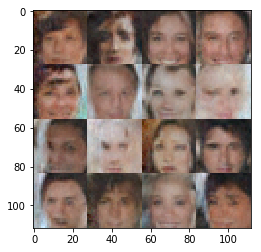

Epoch 1/2... Discriminator loss: 1.3718... Generator loss: 0.7351
Epoch 1/2... Discriminator loss: 1.3741... Generator loss: 0.7896
Epoch 1/2... Discriminator loss: 1.4317... Generator loss: 0.7721
Epoch 1/2... Discriminator loss: 1.4045... Generator loss: 0.7131
Epoch 1/2... Discriminator loss: 1.3875... Generator loss: 0.7484
Epoch 1/2... Discriminator loss: 1.3294... Generator loss: 0.8191
Epoch 1/2... Discriminator loss: 1.3782... Generator loss: 0.8267
Epoch 1/2... Discriminator loss: 1.3109... Generator loss: 0.8358
Epoch 1/2... Discriminator loss: 1.4299... Generator loss: 0.8645
Epoch 1/2... Discriminator loss: 1.3655... Generator loss: 0.7415


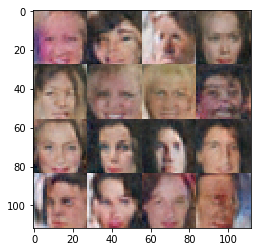

Epoch 1/2... Discriminator loss: 1.3818... Generator loss: 0.7212
Epoch 1/2... Discriminator loss: 1.3838... Generator loss: 0.7580
Epoch 1/2... Discriminator loss: 1.3186... Generator loss: 0.7959
Epoch 1/2... Discriminator loss: 1.3507... Generator loss: 0.8280
Epoch 1/2... Discriminator loss: 1.3554... Generator loss: 0.8227
Epoch 1/2... Discriminator loss: 1.3819... Generator loss: 0.8305
Epoch 1/2... Discriminator loss: 1.3555... Generator loss: 0.7285
Epoch 1/2... Discriminator loss: 1.3500... Generator loss: 0.7981
Epoch 1/2... Discriminator loss: 1.3511... Generator loss: 0.7616
Epoch 1/2... Discriminator loss: 1.3299... Generator loss: 0.7473


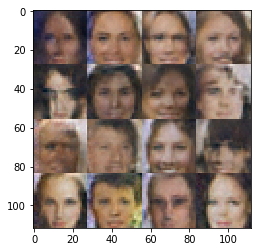

Epoch 1/2... Discriminator loss: 1.4072... Generator loss: 0.8021
Epoch 1/2... Discriminator loss: 1.3542... Generator loss: 0.7628
Epoch 1/2... Discriminator loss: 1.3946... Generator loss: 0.7622
Epoch 1/2... Discriminator loss: 1.2735... Generator loss: 0.8481
Epoch 1/2... Discriminator loss: 1.3774... Generator loss: 0.7827
Epoch 1/2... Discriminator loss: 1.3413... Generator loss: 0.7844
Epoch 1/2... Discriminator loss: 1.3636... Generator loss: 0.7526
Epoch 1/2... Discriminator loss: 1.3396... Generator loss: 0.8442
Epoch 1/2... Discriminator loss: 1.4642... Generator loss: 0.7582
Epoch 1/2... Discriminator loss: 1.3365... Generator loss: 0.8411


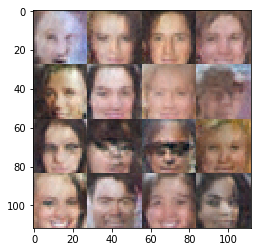

Epoch 1/2... Discriminator loss: 1.3995... Generator loss: 0.7479
Epoch 1/2... Discriminator loss: 1.3219... Generator loss: 0.8974
Epoch 1/2... Discriminator loss: 1.4178... Generator loss: 0.7612
Epoch 1/2... Discriminator loss: 1.3556... Generator loss: 0.7882
Epoch 1/2... Discriminator loss: 1.3913... Generator loss: 0.7728
Epoch 1/2... Discriminator loss: 1.3267... Generator loss: 0.7897
Epoch 1/2... Discriminator loss: 1.3643... Generator loss: 0.8468
Epoch 1/2... Discriminator loss: 1.3580... Generator loss: 0.8023
Epoch 1/2... Discriminator loss: 1.4523... Generator loss: 0.8062
Epoch 1/2... Discriminator loss: 1.3620... Generator loss: 0.8698


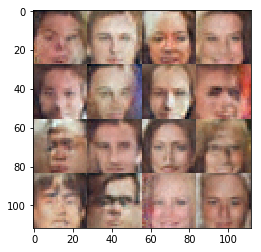

Epoch 1/2... Discriminator loss: 1.3173... Generator loss: 0.8091
Epoch 1/2... Discriminator loss: 1.3402... Generator loss: 0.8458
Epoch 1/2... Discriminator loss: 1.3763... Generator loss: 0.7679
Epoch 1/2... Discriminator loss: 1.3761... Generator loss: 0.7689
Epoch 1/2... Discriminator loss: 1.2915... Generator loss: 0.8798
Epoch 1/2... Discriminator loss: 1.3956... Generator loss: 0.8416
Epoch 1/2... Discriminator loss: 1.3381... Generator loss: 0.8925
Epoch 1/2... Discriminator loss: 1.3705... Generator loss: 0.7985
Epoch 1/2... Discriminator loss: 1.3727... Generator loss: 0.7925
Epoch 1/2... Discriminator loss: 1.3370... Generator loss: 0.7903


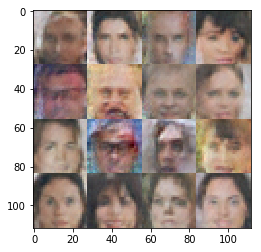

Epoch 1/2... Discriminator loss: 1.3276... Generator loss: 0.7694
Epoch 1/2... Discriminator loss: 1.3751... Generator loss: 0.8225
Epoch 1/2... Discriminator loss: 1.3197... Generator loss: 0.8199
Epoch 1/2... Discriminator loss: 1.3849... Generator loss: 0.8198
Epoch 1/2... Discriminator loss: 1.3055... Generator loss: 0.8677
Epoch 1/2... Discriminator loss: 1.3381... Generator loss: 0.8507
Epoch 1/2... Discriminator loss: 1.3277... Generator loss: 0.8226
Epoch 1/2... Discriminator loss: 1.3582... Generator loss: 0.8565
Epoch 1/2... Discriminator loss: 1.3631... Generator loss: 0.7854
Epoch 1/2... Discriminator loss: 1.3378... Generator loss: 0.7491


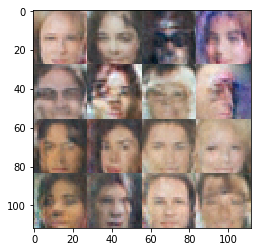

Epoch 1/2... Discriminator loss: 1.3090... Generator loss: 0.7992
Epoch 1/2... Discriminator loss: 1.4128... Generator loss: 0.8376
Epoch 1/2... Discriminator loss: 1.3260... Generator loss: 0.8428
Epoch 1/2... Discriminator loss: 1.3555... Generator loss: 0.8139
Epoch 1/2... Discriminator loss: 1.3302... Generator loss: 0.7893
Epoch 1/2... Discriminator loss: 1.3793... Generator loss: 0.7788


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.